In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "M-type_MADS"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn002551,MKRIENATSRQVTFSKRRNGLLKKAFELSVLCDAEVALIIFSNKGR...,126,1
1,Achn015591,MGRSVKHESITNERVRRQTFQKRKAGLFKKVSELQTLCGHDACAVI...,165,1
2,Achn041671,MAREKIKIKKIDNITARQVTFSKRRRGLFKKAEELAVLCDAEVALI...,93,1
3,Achn041761,MGRGKIVIRRIDNSTSRQVTFSKRRNGLLKKAKELAILCDAEVGVI...,91,1
4,Achn058181,MTRNKINLALIANESSRKATLKKRRASMFKKIEELSVLSDVRTGAI...,253,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
9904,0.008850,0.000000,0.000000,0.000000,0.00000,0.00000,0.008850,0.000000,0.008850,0.000000,...,0.000000,0.000000,0.008850,0.008850,0.000000,0.000000,0.0,0.000000,0.0,0.000000
11310,0.011628,0.002326,0.002326,0.002326,0.00000,0.00000,0.004651,0.000000,0.002326,0.004651,...,0.004651,0.002326,0.000000,0.000000,0.002326,0.000000,0.0,0.002326,0.0,0.000000
446,0.000000,0.003040,0.003040,0.000000,0.00304,0.00304,0.000000,0.000000,0.000000,0.009119,...,0.003040,0.006079,0.000000,0.000000,0.009119,0.003040,0.0,0.000000,0.0,0.003040
1633,0.000000,0.000000,0.006098,0.000000,0.00000,0.00000,0.006098,0.006098,0.006098,0.006098,...,0.000000,0.000000,0.000000,0.000000,0.006098,0.000000,0.0,0.000000,0.0,0.000000
7295,0.006803,0.000000,0.006803,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006803,0.006803,0.000000,0.006803,0.0,0.000000,0.0,0.006803


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (12040, 441)
X_test: (3011, 441)
y_train: (12040,)
y_test: (3011,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1:10 467ms/step - accuracy: 0.4844 - loss: 0.6932

 30/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5770 - loss: 0.6877    

 60/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6497 - loss: 0.6546

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6989 - loss: 0.6009

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7304 - loss: 0.5566

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7525 - loss: 0.5222

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7538 - loss: 0.5200 - val_accuracy: 0.9306 - val_loss: 0.1929


Epoch 2/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9531 - loss: 0.1752

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9339 - loss: 0.2096

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9395 - loss: 0.1913

 84/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9423 - loss: 0.1820

112/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9438 - loss: 0.1767

140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9449 - loss: 0.1725

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9453 - loss: 0.1710 - val_accuracy: 0.9502 - val_loss: 0.1356


Epoch 3/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9688 - loss: 0.1135

 30/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9579 - loss: 0.1185

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9576 - loss: 0.1226

 86/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9577 - loss: 0.1238

114/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9575 - loss: 0.1248

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9565 - loss: 0.1272

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9562 - loss: 0.1279 - val_accuracy: 0.9456 - val_loss: 0.1500


Epoch 4/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9531 - loss: 0.0911

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9536 - loss: 0.1194

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9571 - loss: 0.1188

 86/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9590 - loss: 0.1179

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9593 - loss: 0.1180

117/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9593 - loss: 0.1192

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9589 - loss: 0.1207

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9588 - loss: 0.1210 - val_accuracy: 0.9547 - val_loss: 0.1231


Epoch 5/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9375 - loss: 0.1521

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9608 - loss: 0.1187

 53/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9620 - loss: 0.1121

 80/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9619 - loss: 0.1113

107/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9621 - loss: 0.1110

135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9622 - loss: 0.1107

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9622 - loss: 0.1109 - val_accuracy: 0.9560 - val_loss: 0.1303


Epoch 6/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9688 - loss: 0.0866

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9640 - loss: 0.1064

 55/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9628 - loss: 0.1086

 82/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9627 - loss: 0.1082

111/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9627 - loss: 0.1083

139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9629 - loss: 0.1080

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9629 - loss: 0.1081 - val_accuracy: 0.9365 - val_loss: 0.1550


Epoch 7/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9375 - loss: 0.1939

 27/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9575 - loss: 0.1193

 54/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9618 - loss: 0.1124

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9636 - loss: 0.1085

105/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.1065

131/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9645 - loss: 0.1048

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9648 - loss: 0.1034 - val_accuracy: 0.9622 - val_loss: 0.1043


Epoch 8/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0256

 27/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9734 - loss: 0.0828

 55/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9719 - loss: 0.0859

 82/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9718 - loss: 0.0852

109/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9718 - loss: 0.0848

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9719 - loss: 0.0840

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9720 - loss: 0.0835 - val_accuracy: 0.9668 - val_loss: 0.0952


Epoch 9/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9531 - loss: 0.1358

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9690 - loss: 0.0963

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9712 - loss: 0.0864

 84/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9724 - loss: 0.0816

111/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9732 - loss: 0.0793

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9740 - loss: 0.0774

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9743 - loss: 0.0766 - val_accuracy: 0.9676 - val_loss: 0.0890


Epoch 10/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0169

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0499

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0535

 85/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0545

111/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.0552

140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0554

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0554 - val_accuracy: 0.9684 - val_loss: 0.1003


Epoch 11/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0080

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9888 - loss: 0.0332

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0404

 82/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9857 - loss: 0.0425

108/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0433

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0436

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0437 - val_accuracy: 0.9693 - val_loss: 0.0888


Epoch 12/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9844 - loss: 0.0406

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9857 - loss: 0.0398

 55/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.0416

 82/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.0416

109/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.0419

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0421

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0422 - val_accuracy: 0.9730 - val_loss: 0.0911


Epoch 13/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0050

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0366

 53/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9843 - loss: 0.0394

 80/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.0393

107/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0386

133/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.0385

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.0386 - val_accuracy: 0.9726 - val_loss: 0.0867


Epoch 14/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9844 - loss: 0.0433

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0231

 55/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0233

 82/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0249

110/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0270

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0283

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0286 - val_accuracy: 0.9718 - val_loss: 0.0885


Epoch 15/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9844 - loss: 0.0329

 30/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0230

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0229

 84/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0229

108/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0227

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0224

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0222 - val_accuracy: 0.9722 - val_loss: 0.0968


Epoch 16/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9688 - loss: 0.0663

 27/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0217

 53/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0188

 83/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0197

110/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0224

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0246

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0254 - val_accuracy: 0.9743 - val_loss: 0.0932


Epoch 17/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0066

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0162

 55/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0162

 82/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0163

109/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0164

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0170

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0172 - val_accuracy: 0.9734 - val_loss: 0.0935


Epoch 18/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0021

 27/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0126

 54/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0113

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0107

108/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0106

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0109

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0111 - val_accuracy: 0.9680 - val_loss: 0.1152


Epoch 19/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0051

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0163

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0167

 83/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0212

111/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0240

140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0250

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0253 - val_accuracy: 0.9684 - val_loss: 0.1019


Epoch 20/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9844 - loss: 0.0615

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0185

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0137

 82/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0121

109/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0116

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0115

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0115 - val_accuracy: 0.9722 - val_loss: 0.1012


Epoch 21/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0211

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0167

 55/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0158

 83/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0147

110/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0137

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0128

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0126 - val_accuracy: 0.9759 - val_loss: 0.1098


Epoch 22/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.0026e-04

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0059    

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0074

 85/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0084

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0089

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0097

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0101 - val_accuracy: 0.9655 - val_loss: 0.1145


Epoch 23/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0020

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0189

 54/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0203

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0235

108/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0245

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0244

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0241 - val_accuracy: 0.9738 - val_loss: 0.1017


Epoch 24/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0111

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0092

 85/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0085

114/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0080

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0080

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0082 - val_accuracy: 0.9701 - val_loss: 0.1160


Epoch 25/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0044

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0186

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0148

 84/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0135

110/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0128

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0121

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0119 - val_accuracy: 0.9718 - val_loss: 0.1134


Epoch 26/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0024

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0038

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0046

 84/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0047

111/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0045

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0043

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0042 - val_accuracy: 0.9726 - val_loss: 0.1339


Epoch 27/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 6.9979e-04

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0106    

 55/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0111

 83/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0110

111/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0110

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0111

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0112 - val_accuracy: 0.9639 - val_loss: 0.1491


Epoch 28/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0108

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0154

 54/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0163

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0159

107/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0156

134/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0153

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0151 - val_accuracy: 0.9776 - val_loss: 0.0968


Epoch 29/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0053

 27/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0068

 55/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0067

 83/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0062

112/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0059

139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0057

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0056 - val_accuracy: 0.9718 - val_loss: 0.1320


Epoch 30/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9844 - loss: 0.0254

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0065

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0059

 82/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0064

109/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0093

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0114

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0121 - val_accuracy: 0.9763 - val_loss: 0.0952


Epoch 31/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0018

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0100

 53/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0107

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0101

110/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0094

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0092

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0091 - val_accuracy: 0.9738 - val_loss: 0.1036


Epoch 32/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0036

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0118

 53/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0104

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0093

108/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0085

135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0081

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0078 - val_accuracy: 0.9772 - val_loss: 0.1103


Epoch 33/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1310e-04

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0020    

 54/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0038

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0048

109/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0053

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0054

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0056 - val_accuracy: 0.9755 - val_loss: 0.1265


Epoch 34/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 4.1254e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0043    

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0042

 86/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0040

114/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0041

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0044

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 0.9738 - val_loss: 0.1296


Epoch 35/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0029

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0259

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0360

 83/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0365

111/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0346

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0325

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0315 - val_accuracy: 0.9759 - val_loss: 0.1035


Epoch 36/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9844 - loss: 0.0336

 27/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0120

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0095

 83/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0090

110/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0088

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0085

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0084 - val_accuracy: 0.9755 - val_loss: 0.1111


Epoch 37/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0011

 27/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0026

 54/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0029

 80/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0030

106/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0030

133/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0035

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0041 - val_accuracy: 0.9713 - val_loss: 0.1115


Epoch 38/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0034

 28/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0038

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0046

 84/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0049

110/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0051

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0052

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0053 - val_accuracy: 0.9709 - val_loss: 0.1376



[Train Accuracy: 99.83% - Test Accuracy: 96.75%]


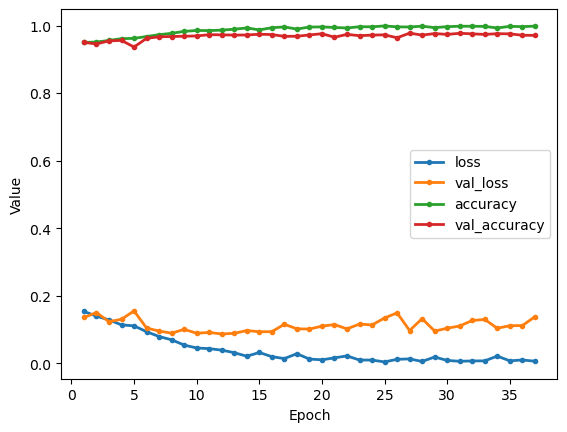

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


 1/95 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
9904,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11310,0.002331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002331,0.002331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1633,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7295,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (12040, 9013)
X_test: (3011, 9013)
y_train: (12040,)
y_test: (3011,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,307,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,350,849 (8.97 MB)

 Trainable params: 2,350,849 (8.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1:15 506ms/step - accuracy: 0.5781 - loss: 0.6931

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5138 - loss: 0.6931    

 17/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5338 - loss: 0.6925

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5699 - loss: 0.6910

 33/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6008 - loss: 0.6884

 41/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6284 - loss: 0.6835

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6524 - loss: 0.6751

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6731 - loss: 0.6625

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6911 - loss: 0.6469

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7069 - loss: 0.6300

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7210 - loss: 0.6127

 89/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7334 - loss: 0.5959

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7446 - loss: 0.5796

104/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7534 - loss: 0.5658

111/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7616 - loss: 0.5527

119/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7701 - loss: 0.5385

126/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7769 - loss: 0.5267

134/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7842 - loss: 0.5138

142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7909 - loss: 0.5016

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7963 - loss: 0.4914

151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7986 - loss: 0.4872 - val_accuracy: 0.9772 - val_loss: 0.0723


Epoch 2/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9844 - loss: 0.1019

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9891 - loss: 0.0531 

 16/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9888 - loss: 0.0457

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9892 - loss: 0.0417

 30/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9896 - loss: 0.0390

 37/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9900 - loss: 0.0370

 45/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9905 - loss: 0.0351

 53/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9907 - loss: 0.0339

 60/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9908 - loss: 0.0333

 67/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9908 - loss: 0.0333

 75/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9908 - loss: 0.0331

 82/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9909 - loss: 0.0330

 90/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9909 - loss: 0.0329

 98/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9909 - loss: 0.0329

106/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9908 - loss: 0.0329

114/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9908 - loss: 0.0329

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9908 - loss: 0.0329

130/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9907 - loss: 0.0330

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9907 - loss: 0.0330

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9906 - loss: 0.0329

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9906 - loss: 0.0329 - val_accuracy: 0.9850 - val_loss: 0.0499


Epoch 3/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 1.0000 - loss: 0.0055

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0074 

 16/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0086

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0086

 32/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0087

 40/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0086

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0084

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0083

 64/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0081

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0080

 80/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0079

 87/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0079

 95/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0078

103/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0078

111/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0078

119/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0079

127/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0079

135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0080

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0081

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9982 - loss: 0.0082 - val_accuracy: 0.9838 - val_loss: 0.0557


Epoch 4/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9844 - loss: 0.0537

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9951 - loss: 0.0182 

 17/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9968 - loss: 0.0125

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9976 - loss: 0.0099

 33/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9979 - loss: 0.0084

 42/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0073

 51/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9984 - loss: 0.0066

 59/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0061

 67/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0057

 75/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0054

 83/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0052

 91/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0050

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0049

108/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0048

116/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0047

124/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0046

132/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0046

140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0045

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0045

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9987 - loss: 0.0045 - val_accuracy: 0.9867 - val_loss: 0.0556


Epoch 5/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 5.9106e-04

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4102e-04 

 17/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2018e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1870e-04

 33/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2078e-04

 41/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2177e-04

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2389e-04

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2585e-04

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4055e-04

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6777e-04

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9163e-04

 89/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2022e-04

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4839e-04

105/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7048e-04

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8705e-04

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 5.9855e-04

129/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 6.0670e-04

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 6.1296e-04

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 6.1738e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 6.2417e-04 - val_accuracy: 0.9817 - val_loss: 0.0711


Epoch 6/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 5.3656e-04

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.2028e-04 

 17/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.3378e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1584e-04

 34/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1840e-04

 42/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.3288e-04

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4763e-04

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7076e-04

 66/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7849e-04

 74/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7598e-04

 82/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7331e-04

 90/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7607e-04

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8859e-04

107/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.9870e-04

115/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0431e-04

123/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 9.1636e-04

131/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 9.3216e-04

139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 9.4848e-04

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 9.6823e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 9.7892e-04 - val_accuracy: 0.9755 - val_loss: 0.1023


Epoch 7/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 0.0024

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0541e-04

 17/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.7643e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1451e-04

 33/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7583e-04

 41/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4503e-04

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0010    

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0014

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0017

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0018

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0019

 89/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0020

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0020

105/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0020

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0020

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0020

129/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0020

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0020

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0020

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 0.0020 - val_accuracy: 0.9850 - val_loss: 0.0692


Epoch 8/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 8.7878e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5164e-04 

 17/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5294e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6670e-04

 33/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6824e-04

 41/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6711e-04

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6473e-04

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6246e-04

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6007e-04

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6037e-04

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6039e-04

 89/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6117e-04

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6190e-04

105/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6198e-04

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6185e-04

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6157e-04

129/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6233e-04

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6407e-04

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6546e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.6657e-04 - val_accuracy: 0.9842 - val_loss: 0.0789


Epoch 9/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 6.2373e-04

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2204e-04 

 18/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5823e-04

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3797e-04

 34/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3605e-04

 42/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3563e-04

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3315e-04

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3067e-04

 66/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2810e-04

 74/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2629e-04

 82/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2442e-04

 90/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2236e-04

 98/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2018e-04

107/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1774e-04

116/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1561e-04

125/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1386e-04

133/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1239e-04

142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1076e-04

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0956e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0929e-04 - val_accuracy: 0.9863 - val_loss: 0.0775


Epoch 10/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 2.4880e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7272e-05 

 17/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3957e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2452e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2189e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1978e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2034e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1979e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1898e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1789e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1692e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1803e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2118e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2393e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2620e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2770e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2872e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2954e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2998e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.3024e-05 - val_accuracy: 0.9850 - val_loss: 0.0795


Epoch 11/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 7.0845e-04

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3814e-04 

 17/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6152e-04

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3588e-04

 35/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2570e-04

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1763e-04

 51/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1113e-04

 59/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0523e-04

 67/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0001e-04

 75/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5436e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1360e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7733e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4626e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1978e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.9874e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.8048e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6206e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4661e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3208e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.2513e-05 - val_accuracy: 0.9850 - val_loss: 0.0807


Epoch 12/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 1.5464e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5547e-05 

 17/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5704e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5671e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5614e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5854e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6147e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6365e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6730e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7174e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7493e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7808e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8033e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8193e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8307e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8418e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8476e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8534e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8619e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.8672e-05 - val_accuracy: 0.9859 - val_loss: 0.0831


Epoch 13/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 5.2798e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3354e-05 

 18/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5137e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5859e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6106e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6207e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6992e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7584e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8025e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8408e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8699e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8918e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9086e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9352e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9590e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9789e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9961e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0072e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0131e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.0143e-05 - val_accuracy: 0.9859 - val_loss: 0.0842


Epoch 14/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 1.0000 - loss: 8.4303e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1909e-06 

 17/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7810e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0902e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1823e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2553e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3179e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3444e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3728e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3962e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4094e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4365e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5168e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6269e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7133e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7805e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8339e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8786e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9193e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.9499e-05 - val_accuracy: 0.9855 - val_loss: 0.0841



[Train Accuracy: 100.00% - Test Accuracy: 98.37%]


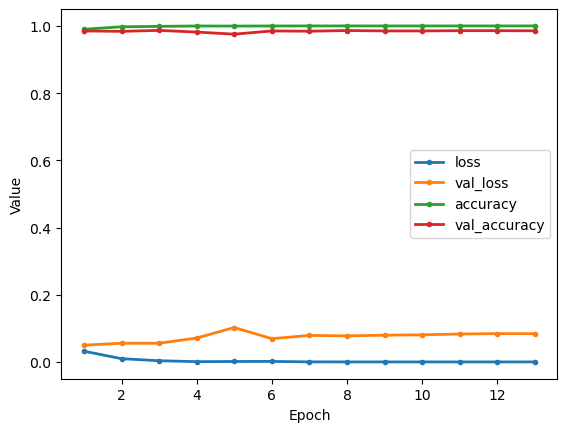

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/95 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

57/95 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 1/95 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

57/95 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
9904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002336,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      40,663,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,704,513 (155.28 MB)

 Trainable params: 40,704,513 (155.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1:40 673ms/step - accuracy: 0.5469 - loss: 0.6931

  2/151 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.5273 - loss: 0.6931 

  3/151 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5234 - loss: 0.6931

  4/151 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.5146 - loss: 0.6931

  5/151 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.5123 - loss: 0.6931

  6/151 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.5112 - loss: 0.6931

  7/151 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.5124 - loss: 0.6931

  8/151 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.5128 - loss: 0.6931

  9/151 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.5124 - loss: 0.6930

 10/151 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.5130 - loss: 0.6930

 11/151 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.5129 - loss: 0.6929

 12/151 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.5125 - loss: 0.6929

 13/151 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.5132 - loss: 0.6929

 14/151 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.5138 - loss: 0.6928

 15/151 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.5152 - loss: 0.6928

 16/151 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.5175 - loss: 0.6927

 17/151 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.5201 - loss: 0.6927

 18/151 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.5229 - loss: 0.6926

 19/151 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.5254 - loss: 0.6925

 20/151 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.5281 - loss: 0.6924

 21/151 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.5308 - loss: 0.6923

 22/151 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.5330 - loss: 0.6922

 23/151 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.5354 - loss: 0.6921

 24/151 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.5377 - loss: 0.6920

 25/151 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.5401 - loss: 0.6919

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.5426 - loss: 0.6917

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.5452 - loss: 0.6916

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.5479 - loss: 0.6914

 29/151 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.5508 - loss: 0.6913

 30/151 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.5536 - loss: 0.6911

 31/151 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.5565 - loss: 0.6909

 32/151 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.5594 - loss: 0.6907

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5622 - loss: 0.6905

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5649 - loss: 0.6902

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5676 - loss: 0.6900

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5703 - loss: 0.6897

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5730 - loss: 0.6894

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5757 - loss: 0.6891

 39/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.5786 - loss: 0.6888

 40/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.5814 - loss: 0.6884

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.5841 - loss: 0.6880

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.5869 - loss: 0.6876

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.5896 - loss: 0.6872

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.5923 - loss: 0.6867

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.5949 - loss: 0.6862

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.5975 - loss: 0.6856

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.6001 - loss: 0.6850

 48/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.6027 - loss: 0.6844

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.6052 - loss: 0.6837

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.6076 - loss: 0.6830

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.6100 - loss: 0.6823

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.6124 - loss: 0.6815

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.6147 - loss: 0.6807

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.6170 - loss: 0.6798

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.6193 - loss: 0.6789

 56/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.6215 - loss: 0.6780

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.6238 - loss: 0.6770

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.6260 - loss: 0.6760

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.6281 - loss: 0.6749

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.6303 - loss: 0.6738

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.6324 - loss: 0.6727

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.6345 - loss: 0.6715

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.6366 - loss: 0.6703

 64/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6387 - loss: 0.6690

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6407 - loss: 0.6677

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6428 - loss: 0.6664

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6448 - loss: 0.6650

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6468 - loss: 0.6636

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6487 - loss: 0.6622

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6506 - loss: 0.6607

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6526 - loss: 0.6592

 72/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6544 - loss: 0.6577 

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6563 - loss: 0.6562

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6582 - loss: 0.6546

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6600 - loss: 0.6530

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6618 - loss: 0.6514

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6636 - loss: 0.6497

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6654 - loss: 0.6481

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6671 - loss: 0.6464

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6689 - loss: 0.6447

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.6706 - loss: 0.6430

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6723 - loss: 0.6412

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.6740 - loss: 0.6395

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6756 - loss: 0.6377

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6773 - loss: 0.6359

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6789 - loss: 0.6341

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6805 - loss: 0.6323

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6821 - loss: 0.6305

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6837 - loss: 0.6287

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6853 - loss: 0.6269

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6868 - loss: 0.6250

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6883 - loss: 0.6232

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6898 - loss: 0.6214

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6913 - loss: 0.6196

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6928 - loss: 0.6177

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6943 - loss: 0.6159

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6957 - loss: 0.6141

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6972 - loss: 0.6123

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6986 - loss: 0.6104

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7000 - loss: 0.6086

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7014 - loss: 0.6068

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7028 - loss: 0.6049

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7041 - loss: 0.6031

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7055 - loss: 0.6013

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7068 - loss: 0.5995

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7082 - loss: 0.5977

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7095 - loss: 0.5959

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7108 - loss: 0.5941

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7120 - loss: 0.5923

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7133 - loss: 0.5906

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7146 - loss: 0.5888

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7158 - loss: 0.5870

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7170 - loss: 0.5853

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7183 - loss: 0.5835

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7195 - loss: 0.5818

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7207 - loss: 0.5800

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7219 - loss: 0.5783

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7230 - loss: 0.5766

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7242 - loss: 0.5748

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7253 - loss: 0.5731

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7265 - loss: 0.5715

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7276 - loss: 0.5698

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7287 - loss: 0.5681

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7298 - loss: 0.5665

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7309 - loss: 0.5648

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7320 - loss: 0.5632

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7330 - loss: 0.5616

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7341 - loss: 0.5600

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7351 - loss: 0.5584

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7362 - loss: 0.5568

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7372 - loss: 0.5552

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7382 - loss: 0.5536

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7392 - loss: 0.5520

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7402 - loss: 0.5505

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7412 - loss: 0.5489

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7422 - loss: 0.5474

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7432 - loss: 0.5458

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7441 - loss: 0.5443

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7451 - loss: 0.5428

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7460 - loss: 0.5413

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7470 - loss: 0.5398

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7479 - loss: 0.5383

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7488 - loss: 0.5368

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7497 - loss: 0.5353

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7506 - loss: 0.5339

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7515 - loss: 0.5324

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7524 - loss: 0.5309

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7533 - loss: 0.5295

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7542 - loss: 0.5281

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7551 - loss: 0.5266

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7559 - loss: 0.5252

151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.7568 - loss: 0.5238 - val_accuracy: 0.9896 - val_loss: 0.0368


Epoch 2/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 36s 244ms/step - accuracy: 1.0000 - loss: 0.0141

  2/151 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 1.0000 - loss: 0.0130

  3/151 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 1.0000 - loss: 0.0129

  4/151 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 1.0000 - loss: 0.0126

  5/151 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 1.0000 - loss: 0.0127

  6/151 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 1.0000 - loss: 0.0126

  7/151 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9997 - loss: 0.0128

  8/151 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9995 - loss: 0.0131

  9/151 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9990 - loss: 0.0140

 10/151 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9986 - loss: 0.0147

 11/151 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9983 - loss: 0.0152

 12/151 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9981 - loss: 0.0156

 13/151 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9980 - loss: 0.0159

 14/151 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9978 - loss: 0.0163

 15/151 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.9976 - loss: 0.0168

 16/151 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.9975 - loss: 0.0172

 17/151 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.9973 - loss: 0.0176

 18/151 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.9971 - loss: 0.0182

 19/151 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 0.9970 - loss: 0.0186

 20/151 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 0.9968 - loss: 0.0190

 21/151 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.9967 - loss: 0.0193

 22/151 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.9967 - loss: 0.0196

 23/151 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.9966 - loss: 0.0198

 24/151 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.9965 - loss: 0.0202

 25/151 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.9964 - loss: 0.0205

 26/151 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9963 - loss: 0.0207

 27/151 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9963 - loss: 0.0209

 28/151 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9962 - loss: 0.0211

 29/151 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9961 - loss: 0.0213

 30/151 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.9961 - loss: 0.0215

 31/151 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.9960 - loss: 0.0216

 32/151 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.9959 - loss: 0.0218

 33/151 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.9959 - loss: 0.0219

 34/151 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.9958 - loss: 0.0220

 35/151 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.9958 - loss: 0.0221

 36/151 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.9957 - loss: 0.0222

 37/151 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.9957 - loss: 0.0223

 38/151 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9956 - loss: 0.0223

 39/151 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9956 - loss: 0.0224

 40/151 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9955 - loss: 0.0224

 41/151 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9955 - loss: 0.0224

 42/151 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9955 - loss: 0.0225

 43/151 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9955 - loss: 0.0225

 44/151 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9954 - loss: 0.0225

 45/151 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9954 - loss: 0.0225

 46/151 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9954 - loss: 0.0225

 47/151 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9954 - loss: 0.0225

 48/151 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9954 - loss: 0.0225

 49/151 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.9954 - loss: 0.0225

 50/151 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9953 - loss: 0.0224

 51/151 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9953 - loss: 0.0224

 52/151 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9953 - loss: 0.0224

 53/151 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9953 - loss: 0.0224

 54/151 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9953 - loss: 0.0224

 55/151 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9953 - loss: 0.0224

 56/151 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9953 - loss: 0.0224

 57/151 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9953 - loss: 0.0224

 58/151 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9952 - loss: 0.0224

 59/151 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9952 - loss: 0.0224

 60/151 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9952 - loss: 0.0224

 61/151 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9952 - loss: 0.0224

 62/151 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9952 - loss: 0.0224

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9952 - loss: 0.0224

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9952 - loss: 0.0224

 65/151 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9952 - loss: 0.0224

 66/151 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9952 - loss: 0.0224

 67/151 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9952 - loss: 0.0224

 68/151 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9952 - loss: 0.0224

 69/151 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9952 - loss: 0.0224

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9952 - loss: 0.0224

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9952 - loss: 0.0224

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9952 - loss: 0.0223

 73/151 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9952 - loss: 0.0223

 74/151 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9952 - loss: 0.0223

 75/151 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9952 - loss: 0.0223

 76/151 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9952 - loss: 0.0223

 77/151 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9952 - loss: 0.0223

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9952 - loss: 0.0222 

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9952 - loss: 0.0222

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9952 - loss: 0.0222

 81/151 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9952 - loss: 0.0222

 82/151 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9952 - loss: 0.0221

 83/151 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9952 - loss: 0.0221

 84/151 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9952 - loss: 0.0221

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9952 - loss: 0.0221

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9952 - loss: 0.0220

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9952 - loss: 0.0220

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9952 - loss: 0.0220

 89/151 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9952 - loss: 0.0219

 90/151 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9952 - loss: 0.0219

 91/151 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9952 - loss: 0.0219

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9952 - loss: 0.0218

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9952 - loss: 0.0218

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9952 - loss: 0.0218

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9952 - loss: 0.0217

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9952 - loss: 0.0217

 97/151 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9952 - loss: 0.0216

 98/151 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9952 - loss: 0.0216

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9952 - loss: 0.0216

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9952 - loss: 0.0216

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9952 - loss: 0.0215

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9952 - loss: 0.0215

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9952 - loss: 0.0215

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9952 - loss: 0.0214

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9952 - loss: 0.0214

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9952 - loss: 0.0214

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9952 - loss: 0.0214

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9952 - loss: 0.0213

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9952 - loss: 0.0213

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9952 - loss: 0.0213

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9952 - loss: 0.0213

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9952 - loss: 0.0212

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9952 - loss: 0.0212

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9952 - loss: 0.0212

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9952 - loss: 0.0211

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9952 - loss: 0.0211

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9952 - loss: 0.0211

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9952 - loss: 0.0211

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9952 - loss: 0.0210

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9953 - loss: 0.0210

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9953 - loss: 0.0210

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9953 - loss: 0.0209

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9953 - loss: 0.0209

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9953 - loss: 0.0209

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9953 - loss: 0.0208

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9953 - loss: 0.0208

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9953 - loss: 0.0208

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9953 - loss: 0.0207

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9953 - loss: 0.0207

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9953 - loss: 0.0207

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9953 - loss: 0.0207

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9953 - loss: 0.0206

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9953 - loss: 0.0206

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9953 - loss: 0.0206

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9953 - loss: 0.0205

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9953 - loss: 0.0205

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9953 - loss: 0.0205

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9953 - loss: 0.0204

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9953 - loss: 0.0204

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9953 - loss: 0.0204

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9953 - loss: 0.0203

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9954 - loss: 0.0203

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9954 - loss: 0.0203

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9954 - loss: 0.0202

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9954 - loss: 0.0202

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9954 - loss: 0.0202

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9954 - loss: 0.0201

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9954 - loss: 0.0201

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9954 - loss: 0.0201

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9954 - loss: 0.0201

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9954 - loss: 0.0200

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9954 - loss: 0.0200 - val_accuracy: 0.9875 - val_loss: 0.0312


Epoch 3/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 29s 200ms/step - accuracy: 1.0000 - loss: 0.0010

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 1.0000 - loss: 0.0012

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 1.0000 - loss: 0.0012

  4/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 0.0017

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 0.0019

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 0.0020

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 0.0022

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 0.0022

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 0.0023

 10/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.9998 - loss: 0.0027

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.9997 - loss: 0.0030

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9996 - loss: 0.0033

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9996 - loss: 0.0034

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9995 - loss: 0.0036

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.9995 - loss: 0.0037

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9995 - loss: 0.0037

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.9994 - loss: 0.0038

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9994 - loss: 0.0038

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9994 - loss: 0.0039

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.9994 - loss: 0.0039

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9994 - loss: 0.0039

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.9994 - loss: 0.0039

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.9994 - loss: 0.0039

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.9994 - loss: 0.0039

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9994 - loss: 0.0039

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.9994 - loss: 0.0039

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9994 - loss: 0.0039

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9994 - loss: 0.0039

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9994 - loss: 0.0039

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9994 - loss: 0.0039

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9994 - loss: 0.0039

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9994 - loss: 0.0038

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9994 - loss: 0.0038

 34/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9994 - loss: 0.0038

 35/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9994 - loss: 0.0038

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.9994 - loss: 0.0038

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.9994 - loss: 0.0037

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.9994 - loss: 0.0037

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.9994 - loss: 0.0037

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.9994 - loss: 0.0037

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.9994 - loss: 0.0037

 42/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.9994 - loss: 0.0036

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.9994 - loss: 0.0036

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9995 - loss: 0.0036

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9995 - loss: 0.0036

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9995 - loss: 0.0036

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9995 - loss: 0.0035

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9995 - loss: 0.0035

 49/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9995 - loss: 0.0035

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9995 - loss: 0.0035

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9995 - loss: 0.0035

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9995 - loss: 0.0035

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9995 - loss: 0.0034

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9995 - loss: 0.0034

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9995 - loss: 0.0034

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9995 - loss: 0.0034

 57/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9995 - loss: 0.0034

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9995 - loss: 0.0033

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9995 - loss: 0.0033

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9995 - loss: 0.0033

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9995 - loss: 0.0033

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9995 - loss: 0.0033

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9995 - loss: 0.0033

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9995 - loss: 0.0032

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9995 - loss: 0.0032

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9995 - loss: 0.0032

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9995 - loss: 0.0032

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9995 - loss: 0.0032

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9995 - loss: 0.0032

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9996 - loss: 0.0032

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9996 - loss: 0.0031

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9996 - loss: 0.0031

 73/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9996 - loss: 0.0031

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9996 - loss: 0.0031 

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9996 - loss: 0.0031

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9996 - loss: 0.0031

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9996 - loss: 0.0031

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9996 - loss: 0.0031

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9996 - loss: 0.0030

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9996 - loss: 0.0030

 81/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9996 - loss: 0.0030

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9996 - loss: 0.0030

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9996 - loss: 0.0030

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9996 - loss: 0.0030

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9996 - loss: 0.0030

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9996 - loss: 0.0030

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9996 - loss: 0.0029

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9996 - loss: 0.0029

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9996 - loss: 0.0029

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9996 - loss: 0.0029

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9996 - loss: 0.0029

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9996 - loss: 0.0029

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9996 - loss: 0.0029

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9996 - loss: 0.0029

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9996 - loss: 0.0029

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9996 - loss: 0.0028

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9996 - loss: 0.0028

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9996 - loss: 0.0028

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9996 - loss: 0.0028

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9996 - loss: 0.0028

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9996 - loss: 0.0028

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9996 - loss: 0.0028

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9996 - loss: 0.0028

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9996 - loss: 0.0028

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9996 - loss: 0.0028

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9996 - loss: 0.0027

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9996 - loss: 0.0027

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9996 - loss: 0.0027

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9996 - loss: 0.0027

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9997 - loss: 0.0027

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9997 - loss: 0.0027

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9997 - loss: 0.0027

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9997 - loss: 0.0027

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9997 - loss: 0.0027

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9997 - loss: 0.0027

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9997 - loss: 0.0027

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9997 - loss: 0.0026

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9997 - loss: 0.0026

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9997 - loss: 0.0026

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0026

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0026

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0026

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0026

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0026

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0026

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0026

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0026

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9997 - loss: 0.0026

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9997 - loss: 0.0025

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9997 - loss: 0.0025

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9997 - loss: 0.0025

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9997 - loss: 0.0025

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9997 - loss: 0.0025

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9997 - loss: 0.0025

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9997 - loss: 0.0025

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9997 - loss: 0.0025

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9997 - loss: 0.0025

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9997 - loss: 0.0025

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9997 - loss: 0.0025

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9997 - loss: 0.0025

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9997 - loss: 0.0025

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9997 - loss: 0.0025

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9997 - loss: 0.0024

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9997 - loss: 0.0024

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9997 - loss: 0.0024

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9997 - loss: 0.0024

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9997 - loss: 0.0024

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9997 - loss: 0.0024

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9997 - loss: 0.0024

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9997 - loss: 0.0024

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9997 - loss: 0.0024

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9997 - loss: 0.0024 - val_accuracy: 0.9909 - val_loss: 0.0262


Epoch 4/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 1.0000 - loss: 3.1506e-04

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 3.6545e-04

  3/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 3.7907e-04

  4/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 3.8951e-04

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 1.0000 - loss: 4.1808e-04

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 4.3321e-04

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 4.4209e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 4.4856e-04

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 4.5539e-04

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 4.6023e-04

 11/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 4.6227e-04

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 4.6383e-04

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 4.6621e-04

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 4.6688e-04

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 4.6724e-04

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 4.6669e-04

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 4.6553e-04

 18/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 4.6427e-04

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 4.6266e-04

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 4.6122e-04

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 4.5977e-04

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 4.5793e-04

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 4.5640e-04

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 4.5477e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 4.5379e-04

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 4.5247e-04

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 4.5096e-04

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 4.4933e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 4.4767e-04

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 4.4604e-04

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 4.4446e-04

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 4.4284e-04

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 4.4115e-04

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 4.3939e-04

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 4.3760e-04

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 4.3604e-04

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 4.3453e-04

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 4.3315e-04

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 4.3181e-04

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 4.3077e-04

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 4.2970e-04

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 4.2866e-04

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 4.2777e-04

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 4.2700e-04

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 4.2630e-04

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 4.2568e-04

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 4.2510e-04

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 4.2488e-04

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 4.2459e-04

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 4.2420e-04

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 4.2379e-04

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 4.2337e-04

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 4.2315e-04

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 4.2287e-04

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 4.2256e-04

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 4.2230e-04

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 4.2205e-04

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 4.2197e-04

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 4.2182e-04

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 4.2167e-04

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 4.2148e-04

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 4.2128e-04

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 4.2107e-04

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 4.2085e-04

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 4.2220e-04

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 4.2347e-04

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 4.2467e-04

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 4.2584e-04

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 4.2692e-04

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 4.2790e-04

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 4.2882e-04

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 4.2969e-04

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.3050e-04 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.3128e-04

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.3200e-04

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.3266e-04

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.3326e-04

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.3383e-04

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.3444e-04

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.3523e-04

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.3599e-04

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.3671e-04

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.3738e-04

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.3858e-04

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.3972e-04

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.4084e-04

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.4188e-04

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.4291e-04

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.4388e-04

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.4480e-04

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.4564e-04

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.4649e-04

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.4732e-04

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.4811e-04

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.4885e-04

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.4954e-04

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.5019e-04

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.5079e-04

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.5135e-04

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.5188e-04

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.5236e-04

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.5281e-04

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.5322e-04

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.5360e-04

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.5425e-04

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.5488e-04

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.5549e-04

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.5606e-04

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.5659e-04

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.5711e-04

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.5770e-04

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.5825e-04

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.5877e-04

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.5927e-04

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.5974e-04

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.6017e-04

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.6058e-04

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.6096e-04

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.6132e-04

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.6166e-04

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.6198e-04

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.6227e-04

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.6253e-04

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.6276e-04

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.6297e-04

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.6317e-04

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.6336e-04

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6352e-04

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6369e-04

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6383e-04

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6396e-04

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6406e-04

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6414e-04

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6420e-04

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6424e-04

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.6427e-04

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.6428e-04

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.6428e-04

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.6427e-04

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.6425e-04

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.6422e-04

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.6418e-04

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.6412e-04

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.6406e-04

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.6397e-04

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.6387e-04

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.6377e-04

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.6368e-04

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.6359e-04

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.6348e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.6337e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 4.6325e-04 - val_accuracy: 0.9900 - val_loss: 0.0266


Epoch 5/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 43s 291ms/step - accuracy: 1.0000 - loss: 2.3687e-04

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 1.0000 - loss: 2.0415e-04

  3/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 1.9131e-04

  4/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 1.8122e-04

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 1.7478e-04

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 1.7159e-04

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 1.7062e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 1.7365e-04

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 1.7559e-04

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 1.7699e-04

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 1.7747e-04

 12/151 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 1.0000 - loss: 1.7834e-04

 13/151 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 1.0000 - loss: 1.7853e-04

 14/151 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 1.7845e-04

 15/151 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 1.0000 - loss: 1.7818e-04

 16/151 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 1.0000 - loss: 1.7816e-04

 17/151 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 1.0000 - loss: 1.7792e-04

 18/151 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 1.0000 - loss: 1.7749e-04

 19/151 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 1.0000 - loss: 1.7708e-04

 20/151 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 1.0000 - loss: 1.7652e-04

 21/151 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 1.0000 - loss: 1.7614e-04

 22/151 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 1.0000 - loss: 1.7577e-04

 23/151 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 1.0000 - loss: 1.7530e-04

 24/151 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 1.0000 - loss: 1.7483e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 1.0000 - loss: 1.7457e-04

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 1.0000 - loss: 1.7433e-04

 27/151 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 1.0000 - loss: 1.7398e-04

 28/151 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 1.0000 - loss: 1.7365e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 1.0000 - loss: 1.7345e-04

 30/151 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 1.0000 - loss: 1.7326e-04

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 1.0000 - loss: 1.7315e-04

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 1.0000 - loss: 1.7305e-04

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 1.0000 - loss: 1.7297e-04

 34/151 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 1.7294e-04

 35/151 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 1.7285e-04

 36/151 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 1.7275e-04

 37/151 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 1.7262e-04

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 1.7277e-04

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 1.7300e-04

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 1.7317e-04

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 1.7329e-04

 42/151 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 1.7338e-04

 43/151 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 1.7359e-04

 44/151 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 1.7374e-04

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.7405e-04

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.7442e-04

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.7477e-04

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 1.7509e-04

 49/151 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.7536e-04

 50/151 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.7579e-04

 51/151 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.7617e-04

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.7652e-04

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.7686e-04

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.7716e-04

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.7747e-04

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.7774e-04

 57/151 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.7798e-04

 58/151 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.7820e-04

 59/151 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.7840e-04

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.7855e-04

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.7867e-04

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.7878e-04

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.7887e-04

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.7894e-04

 65/151 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.7948e-04

 66/151 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.8002e-04

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.8053e-04

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.8100e-04

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.8148e-04

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.8191e-04

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.8231e-04

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.8267e-04

 73/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.8308e-04

 74/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.8348e-04

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.8386e-04 

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.8420e-04

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.8452e-04

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.8481e-04

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.8507e-04

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.8533e-04

 81/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.8557e-04

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.8594e-04

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.8628e-04

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.8660e-04

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.8689e-04

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.8717e-04

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.8746e-04

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.8772e-04

 89/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.8797e-04

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 1.8820e-04

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 1.8841e-04

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 1.8861e-04

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.8878e-04

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.8895e-04

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.8910e-04

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.8923e-04

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.8934e-04

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.8945e-04

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.8957e-04

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.8968e-04

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.8978e-04

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.8987e-04

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.8995e-04

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.9003e-04

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.9009e-04

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.9015e-04

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.9019e-04

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.9022e-04

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.9025e-04

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.9029e-04

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.9032e-04

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.9034e-04

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.9036e-04

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.9038e-04

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.9039e-04

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.9045e-04

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.9051e-04

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.9056e-04

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.9060e-04

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.9063e-04

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.9066e-04

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.9070e-04

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.9072e-04

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.9074e-04

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.9076e-04

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.9077e-04

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.9079e-04

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.9081e-04

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.9083e-04

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.9086e-04

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.9093e-04

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.9100e-04

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.9106e-04

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.9112e-04

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.9117e-04

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.9121e-04

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.9126e-04

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.9130e-04

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.9133e-04

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.9136e-04

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.9138e-04

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.9141e-04

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.9142e-04

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9144e-04

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9145e-04

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9145e-04

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9145e-04

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9144e-04

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9144e-04

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9143e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9142e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 1.0000 - loss: 1.9141e-04 - val_accuracy: 0.9896 - val_loss: 0.0274


Epoch 6/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 37s 251ms/step - accuracy: 1.0000 - loss: 6.1805e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 6.9924e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 7.5853e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 8.2220e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 8.6197e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 8.8108e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 8.9922e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 9.1115e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 9.1492e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 9.1935e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 9.2582e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 9.2993e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 9.3321e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 9.3656e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 9.4071e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 9.4217e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 9.4473e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 9.4548e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 9.4498e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 9.4379e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 9.4489e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 9.4517e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 9.4794e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 9.5028e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 9.5243e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 9.5419e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 9.5569e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 9.5791e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 9.6005e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 9.6167e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 9.6279e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 9.6418e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 9.6507e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 9.6621e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 9.6719e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 9.6819e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 9.6932e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 9.7024e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 9.7102e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 9.7174e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 9.7253e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 9.7314e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 9.7354e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 9.7384e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 9.7507e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 9.7646e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 9.7759e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 9.7839e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 9.7915e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 9.7975e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 9.8019e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 9.8075e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 9.8125e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 9.8174e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 9.8248e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 9.8307e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.8356e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.8380e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.8384e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.8378e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.8357e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.8328e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.8290e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.8252e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 9.8201e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 9.8165e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 9.8118e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 9.8068e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 9.8021e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 9.7977e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 9.7922e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 9.7860e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 9.7791e-05 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 9.7716e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 9.7663e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 9.7604e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 9.7550e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 9.7493e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 9.7449e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 9.7423e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 9.7420e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 9.7418e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 9.7457e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 9.7488e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 9.7519e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 9.7547e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 9.7570e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 9.7594e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 9.7616e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 9.7641e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 9.7660e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 9.7679e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 9.7693e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 9.7702e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 9.7715e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 9.7723e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.7732e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.7737e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.7744e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.7751e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.7760e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.7771e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.7781e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.7786e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.7787e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.7786e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.7781e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.7774e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.7764e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.7752e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.7736e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 9.7719e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 9.7698e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 9.7676e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 9.7664e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 9.7648e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 9.7629e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 9.7609e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 9.7588e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 9.7567e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 9.7545e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 9.7532e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 9.7514e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 9.7497e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 9.7475e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 9.7455e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 9.7436e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.7442e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.7446e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.7448e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.7449e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.7445e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.7439e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.7431e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.7421e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.7412e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.7399e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.7385e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.7369e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.7351e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.7338e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.7327e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.7315e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.7299e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.8859e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.0039e-04

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.0189e-04

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.0336e-04

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.0480e-04

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.0623e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.0763e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 1.0000 - loss: 1.0902e-04 - val_accuracy: 0.9913 - val_loss: 0.0357


Epoch 7/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 1.0000 - loss: 2.5085e-04

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 1.0000 - loss: 2.4835e-04

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 1.0000 - loss: 3.2809e-04

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 4.9668e-04

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 6.0202e-04

  6/151 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 1.0000 - loss: 6.6171e-04

  7/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 7.1864e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 8.6691e-04

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 9.6541e-04

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 0.0010    

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 0.0011

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.9999 - loss: 0.0019

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9998 - loss: 0.0026

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9997 - loss: 0.0031

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9997 - loss: 0.0035

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9996 - loss: 0.0038

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9996 - loss: 0.0040

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9996 - loss: 0.0042

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9996 - loss: 0.0044

 20/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9995 - loss: 0.0045

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9995 - loss: 0.0046

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9995 - loss: 0.0047

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9995 - loss: 0.0048

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9995 - loss: 0.0049

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9995 - loss: 0.0049

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9995 - loss: 0.0049

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9995 - loss: 0.0050

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9995 - loss: 0.0050

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9995 - loss: 0.0050

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9995 - loss: 0.0050

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9995 - loss: 0.0050

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9995 - loss: 0.0050

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9995 - loss: 0.0050

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.9995 - loss: 0.0050

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9995 - loss: 0.0050

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.9995 - loss: 0.0050

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.9995 - loss: 0.0050

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.9995 - loss: 0.0050

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.9995 - loss: 0.0049

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.9995 - loss: 0.0049

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9995 - loss: 0.0049

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9995 - loss: 0.0049

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9995 - loss: 0.0048

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9995 - loss: 0.0048

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9995 - loss: 0.0048

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9995 - loss: 0.0048

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9995 - loss: 0.0047

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9995 - loss: 0.0047

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9995 - loss: 0.0047

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9995 - loss: 0.0046

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9995 - loss: 0.0046

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9995 - loss: 0.0046

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9995 - loss: 0.0046

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9995 - loss: 0.0045

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9996 - loss: 0.0045

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9996 - loss: 0.0045

 57/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9996 - loss: 0.0045

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9996 - loss: 0.0044

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9996 - loss: 0.0044

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9996 - loss: 0.0044

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9996 - loss: 0.0043

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9996 - loss: 0.0043

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9996 - loss: 0.0043

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9996 - loss: 0.0043

 65/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9996 - loss: 0.0042

 66/151 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9996 - loss: 0.0042

 67/151 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9996 - loss: 0.0042

 68/151 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9996 - loss: 0.0042

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9996 - loss: 0.0041

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9996 - loss: 0.0041

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9996 - loss: 0.0041

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9996 - loss: 0.0041

 73/151 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9996 - loss: 0.0040

 74/151 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9996 - loss: 0.0040

 75/151 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9996 - loss: 0.0040

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9996 - loss: 0.0040 

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9996 - loss: 0.0039

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9996 - loss: 0.0039

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9996 - loss: 0.0039

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9996 - loss: 0.0039

 81/151 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9996 - loss: 0.0039

 82/151 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9996 - loss: 0.0038

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9996 - loss: 0.0038

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9996 - loss: 0.0038

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9996 - loss: 0.0038

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9996 - loss: 0.0038

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9996 - loss: 0.0037

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9996 - loss: 0.0037

 89/151 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9996 - loss: 0.0037

 90/151 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9996 - loss: 0.0037

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9996 - loss: 0.0037

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9996 - loss: 0.0036

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9996 - loss: 0.0036

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9996 - loss: 0.0036

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9997 - loss: 0.0036

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9997 - loss: 0.0036

 97/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9997 - loss: 0.0035

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9997 - loss: 0.0035

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9997 - loss: 0.0035

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9997 - loss: 0.0035

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9997 - loss: 0.0035

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9997 - loss: 0.0035

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9997 - loss: 0.0034

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9997 - loss: 0.0034

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9997 - loss: 0.0034

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9997 - loss: 0.0034

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9997 - loss: 0.0034

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9997 - loss: 0.0033

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9997 - loss: 0.0033

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9997 - loss: 0.0033

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9997 - loss: 0.0033

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9997 - loss: 0.0033

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9997 - loss: 0.0033

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9997 - loss: 0.0033

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9997 - loss: 0.0032

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9997 - loss: 0.0032

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9997 - loss: 0.0032

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9997 - loss: 0.0032

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9997 - loss: 0.0032

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9997 - loss: 0.0032

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9997 - loss: 0.0032

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9997 - loss: 0.0031

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9997 - loss: 0.0031

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9997 - loss: 0.0031

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9997 - loss: 0.0031

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9997 - loss: 0.0031

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9997 - loss: 0.0031

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9997 - loss: 0.0031

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9997 - loss: 0.0030

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9997 - loss: 0.0030

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9997 - loss: 0.0030

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9997 - loss: 0.0030

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9997 - loss: 0.0030

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9997 - loss: 0.0030

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9997 - loss: 0.0030

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9997 - loss: 0.0030

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9997 - loss: 0.0029

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9997 - loss: 0.0029

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9997 - loss: 0.0029

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9997 - loss: 0.0029

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9997 - loss: 0.0029

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9997 - loss: 0.0029

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9997 - loss: 0.0029

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9997 - loss: 0.0029

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9997 - loss: 0.0028

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9997 - loss: 0.0028

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9997 - loss: 0.0028

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9997 - loss: 0.0028

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9997 - loss: 0.0028

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9997 - loss: 0.0028

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9997 - loss: 0.0028

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9997 - loss: 0.0028 - val_accuracy: 0.9909 - val_loss: 0.0298


Epoch 8/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 48s 322ms/step - accuracy: 1.0000 - loss: 6.0546e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 5.5807e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 1.0000 - loss: 5.5026e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 1.0000 - loss: 5.6572e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 1.0000 - loss: 5.6943e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 1.0000 - loss: 5.8250e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 1.0000 - loss: 5.9470e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 5.9831e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 5.9857e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 5.9555e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 5.9363e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 5.9036e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 5.8676e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 5.8362e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 5.8090e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 5.8158e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 5.8159e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 5.8192e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 5.8167e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 5.8100e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 5.7963e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 5.7843e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 5.7737e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 5.7638e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 5.7590e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 5.7563e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 5.7560e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 5.7530e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 5.7472e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 5.7436e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 5.7404e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 5.7393e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 5.7362e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 5.7305e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 5.7240e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 5.7167e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 5.7114e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 5.7038e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 5.6968e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 5.6887e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 5.6804e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 5.6750e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 5.6688e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 5.6612e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 5.6580e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 5.6559e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 5.6541e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 5.6572e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 5.6604e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 5.6629e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 5.6649e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 5.6875e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 5.7084e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 5.7294e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 5.7547e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 5.7784e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 5.8034e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 5.8264e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 5.8510e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 5.8740e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 5.8953e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 5.9150e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 5.9368e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 5.9576e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 5.9773e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 5.9959e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 6.0132e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.0290e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.0444e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.0588e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.0722e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.0846e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.0970e-05 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.1084e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.1192e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.1293e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.1388e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.1475e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.1564e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.1649e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.1729e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.1809e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.1890e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.1972e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.2087e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.2199e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.2307e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.2410e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.2514e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.2613e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.2707e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.2797e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.2884e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.2966e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.3042e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.3112e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.3178e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.3238e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.3298e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.3352e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.3403e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.3452e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.3495e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.3535e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.3576e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.3613e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.3648e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.3681e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.3710e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.3741e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.3768e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.3799e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.3829e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.3860e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.3886e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.3909e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.3933e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.3954e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.3974e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.3999e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.4026e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.4051e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.4073e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.4094e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.4115e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.4133e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.4150e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.4164e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.4176e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.4185e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.4193e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.4201e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.4205e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.4208e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.4211e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.4212e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.4216e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.4219e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.4220e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.4219e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.4217e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.4212e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.4205e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4196e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4186e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4175e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4165e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4153e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4140e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4126e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4112e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 6.4097e-05 - val_accuracy: 0.9917 - val_loss: 0.0279


Epoch 9/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 44s 294ms/step - accuracy: 1.0000 - loss: 1.3058e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 1.1723e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 1.2260e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 1.3202e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 1.0000 - loss: 1.4110e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 1.4864e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 1.5899e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 1.6899e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 1.7593e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.8166e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.8699e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.9177e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.9578e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.9981e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 2.0337e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 2.0607e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 2.0833e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.1041e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.1230e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.1432e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.1732e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.2058e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.2368e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.2665e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.2954e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 2.3245e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.3570e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.3865e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.4149e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.4412e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.4684e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.4930e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.5191e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.5433e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.5692e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.5934e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.6153e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.6347e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.6521e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.6691e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.6849e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.7003e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.7148e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.7289e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.7417e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.7542e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.7660e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.7786e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.7918e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.8058e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.8186e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.8314e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.8430e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.8534e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.8630e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.8719e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.8800e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.8910e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.9011e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.9109e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.9198e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.9284e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.9363e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.9444e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.9528e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.9608e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.9684e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.9760e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.9833e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.9899e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.9959e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0015e-05 

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0068e-05

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.0116e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0162e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0213e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0259e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0306e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0348e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0388e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0424e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0460e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0491e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0538e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.0592e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.0647e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.0697e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 3.0746e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0796e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0843e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0891e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 3.0934e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0975e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.1013e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.1049e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.1086e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.1122e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.1156e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.1188e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.1220e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.1258e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.1293e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.1326e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.1358e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.1391e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.1423e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.1453e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.1483e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.1514e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.1549e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.1582e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.1612e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.1640e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.1667e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.1693e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.1718e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.1740e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.1761e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.1781e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.1799e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.1816e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.1832e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.1847e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.1863e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.1879e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.1894e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.1909e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.1923e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.1935e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.1947e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.1958e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.1967e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.1976e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.1985e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.1993e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2000e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2006e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2010e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2015e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2018e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2021e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2023e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.2024e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2025e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2025e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2024e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2025e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2024e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2024e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.2022e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.2021e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 3.2019e-05 - val_accuracy: 0.9921 - val_loss: 0.0292


Epoch 10/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 50s 336ms/step - accuracy: 1.0000 - loss: 1.7557e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 1.0000 - loss: 1.5632e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 1.0000 - loss: 1.5601e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 1.0000 - loss: 1.5484e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 1.6332e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 1.7347e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 1.8094e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 1.8909e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 1.9536e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 1.9984e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 2.0658e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 2.1219e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 2.1781e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 2.2212e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 2.2528e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 2.2743e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 2.2872e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 2.2946e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 2.3005e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 2.3024e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.3028e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.3020e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.2990e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.2953e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 2.2903e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.2844e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.2771e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.2687e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.2595e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.2515e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.2436e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.2352e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.2259e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.2173e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.2099e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.2023e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.1977e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.1953e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.1929e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.1922e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.1906e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.1883e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.1862e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.1835e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.1806e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.1795e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.1784e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.1792e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.1795e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.1796e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.1797e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.1794e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.1792e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.1786e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.1782e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.1773e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.1762e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.1748e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.1738e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.1729e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.1719e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.1709e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.1695e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.1684e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.1670e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.1755e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.1837e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.1916e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.1989e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.2070e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.2161e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.2247e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.2327e-05 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.2402e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.2473e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.2540e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.2604e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.2665e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.2723e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.2794e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.2863e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.2929e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.2991e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.3049e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.3104e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.3156e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.3205e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.3253e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.3302e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.3347e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.3398e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.3447e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.3493e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.3536e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.3578e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.3621e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.3661e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.3699e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.3735e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.3774e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.3810e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.3845e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.3877e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.3908e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.3938e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.3967e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.3995e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4023e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4052e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4079e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4105e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4130e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4155e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4177e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4199e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4219e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4237e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4255e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4272e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4288e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4302e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4316e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4329e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4341e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4351e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4362e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4371e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4381e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4389e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4399e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4407e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4417e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4428e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4438e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4447e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4456e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4464e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4471e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4477e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4483e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4488e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4493e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4497e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.4501e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.4505e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4509e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4513e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4516e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4519e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4521e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4523e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 1.0000 - loss: 2.4525e-05 - val_accuracy: 0.9917 - val_loss: 0.0298


Epoch 11/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - accuracy: 1.0000 - loss: 1.0781e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 1.0000 - loss: 1.6504e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 1.0000 - loss: 1.8642e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 1.0000 - loss: 1.9364e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 1.0000 - loss: 1.9498e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 1.0000 - loss: 1.9889e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 1.9974e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 1.9985e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 1.9929e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 1.9779e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 1.9699e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 1.9550e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 1.9561e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 1.9548e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 1.9516e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 1.9493e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 1.9454e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 1.9376e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.9508e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.9763e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.9958e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 2.0192e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 2.0431e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.0671e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 2.0859e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.1013e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.1195e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.1697e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.2135e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.2513e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.2891e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.3229e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.3522e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.3789e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.4022e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.4228e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.4410e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.4575e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.4722e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 2.4849e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.4961e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.5056e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.5135e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.5203e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.5260e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.5305e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.5343e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.5369e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.5387e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.5398e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.5402e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.5400e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.5393e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.5385e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.5373e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.5359e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.5340e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.5319e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.5295e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.5270e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.5241e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.5209e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.5178e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.5148e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.5117e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.5087e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.5065e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.5042e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.5015e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.4989e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.4963e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.4936e-05 

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.4921e-05

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.4905e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.4891e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.4876e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.4858e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.4839e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.4818e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.4797e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.4773e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.4753e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.4731e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.4709e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.4688e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.4665e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.4645e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.4625e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.4604e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.4582e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.4558e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.4534e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.4510e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.4485e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.4460e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.4436e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.4411e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.4384e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.4358e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.4330e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.4303e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.4274e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.4245e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4216e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4187e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4158e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4129e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4100e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4071e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4043e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4014e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.3985e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.3957e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.3928e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.3900e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.3876e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.3851e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.3826e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.3802e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.3776e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.3750e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.3724e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.3698e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.3671e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.3645e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.3617e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.3590e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3563e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3536e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3510e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3484e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3457e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3430e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3404e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3377e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.3351e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.3324e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.3298e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.3272e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.3245e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.3220e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.3195e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.3169e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.3143e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.3118e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.3092e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.3066e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.3041e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.3016e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.2991e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.2965e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 1.0000 - loss: 2.2940e-05 - val_accuracy: 0.9921 - val_loss: 0.0311


Epoch 12/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 50s 336ms/step - accuracy: 1.0000 - loss: 5.3098e-06

  2/151 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 1.0000 - loss: 6.8283e-06

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 7.8701e-06

  4/151 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 1.0000 - loss: 8.3488e-06

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 8.7585e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 8.9302e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 9.2211e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 9.4105e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 9.5023e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 9.5297e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 9.5563e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 9.6060e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 9.7890e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 3.4389e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 5.4176e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 7.0255e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 8.3442e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 9.4411e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 1.0354e-04

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.1131e-04

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.1779e-04

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.2327e-04

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.2786e-04

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.3663e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.4419e-04

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.5072e-04

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 1.5634e-04

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 1.6119e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 1.6541e-04

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 1.6918e-04

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 1.7247e-04

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 1.7529e-04

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 1.7771e-04

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.7980e-04

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.8157e-04

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 1.8307e-04

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 1.8432e-04

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 1.8536e-04

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 1.8621e-04

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 1.8688e-04

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.8740e-04

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.8779e-04

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.8806e-04

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.8822e-04

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.8828e-04

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.8827e-04

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.8818e-04

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.8802e-04

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.8779e-04

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.8751e-04

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.8717e-04

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.8679e-04

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.8637e-04

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.8594e-04

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.8547e-04

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.8498e-04

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.8446e-04

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.8391e-04

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.8335e-04

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.8276e-04

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.8216e-04

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.8154e-04

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.8092e-04

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.8028e-04

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7963e-04

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7897e-04

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7831e-04

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7764e-04

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7696e-04

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7628e-04

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7560e-04

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7491e-04

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.7422e-04 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.7354e-04

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.7285e-04

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.7216e-04

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.7147e-04

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.7079e-04

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.7010e-04

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.6942e-04

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.6874e-04

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.6806e-04

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.6738e-04

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.6670e-04

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.6603e-04

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.6535e-04

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.6469e-04

 88/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.6402e-04

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.6337e-04

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.6271e-04

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.6206e-04

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.6141e-04

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.6109e-04

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.6077e-04

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.6043e-04

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.6010e-04

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.5976e-04

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.5941e-04

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.5906e-04

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.5871e-04

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.5835e-04

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.5800e-04

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.5765e-04

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5730e-04

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5695e-04

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5659e-04

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5624e-04

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5588e-04

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5552e-04

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5516e-04

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5480e-04

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.5445e-04

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.5409e-04

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.5375e-04

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.5340e-04

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.5306e-04

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.5275e-04

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.5243e-04

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.5211e-04

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.5181e-04

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.5150e-04

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.5119e-04

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.5089e-04

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.5058e-04

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.5027e-04

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.4997e-04

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.4966e-04

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.4935e-04

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.4904e-04

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.4874e-04

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.4843e-04

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.4812e-04

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.4781e-04

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.4751e-04

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.4720e-04

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.4690e-04

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.4660e-04

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.4629e-04

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.4599e-04

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.4569e-04

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.4540e-04

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.4510e-04

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.4480e-04

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4450e-04

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4420e-04

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4393e-04

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4365e-04

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4338e-04

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4310e-04

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4283e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4255e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 1.4228e-04 - val_accuracy: 0.9917 - val_loss: 0.0305


Epoch 13/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 36s 244ms/step - accuracy: 1.0000 - loss: 1.9606e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 1.0000 - loss: 1.6244e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 1.0000 - loss: 1.5120e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 1.4186e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 1.0000 - loss: 1.3368e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 1.7074e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 1.9107e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 2.0410e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 2.1087e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 2.1428e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 2.1728e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 2.1853e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 2.1871e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 1.0000 - loss: 2.1819e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 2.1718e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 2.1567e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 2.1420e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 2.1262e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 2.1078e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.0987e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 2.0874e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 2.0763e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 2.0642e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.0510e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 2.0375e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.0241e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 2.0109e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 1.9974e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 1.9841e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 1.9707e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 1.9570e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 1.9438e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.9310e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 1.9182e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 1.9064e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 1.8946e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 1.8833e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 1.8719e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 1.8610e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.8502e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.8392e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.8282e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.8174e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.8067e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.7964e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.7870e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.7776e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.7683e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.7590e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.7497e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.7404e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.7313e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.7222e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.7132e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.7043e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 1.6959e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 1.6875e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 1.6797e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 1.6720e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 1.6645e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 1.6572e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 1.6500e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 1.6429e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.6358e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.6290e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.6225e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.6162e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.6099e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.6037e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.5975e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.5914e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.5855e-05 

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.5798e-05

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.5742e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.5686e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.5630e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.5577e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.5525e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.5473e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.5423e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.5381e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.5342e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.5302e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.5263e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.5224e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.5186e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.5147e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.5110e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.5073e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.5039e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.5005e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.4972e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.4939e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.4907e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.4876e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.4846e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.4817e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.4789e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.4762e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.4734e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.4706e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.4679e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.4652e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4625e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4598e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4572e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4546e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4521e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4499e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4478e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4457e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4437e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4416e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4395e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4374e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4354e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4334e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4314e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4294e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4274e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4255e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4237e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4218e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4200e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4181e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4162e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4144e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4126e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4108e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4090e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4072e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4054e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4036e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4019e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4002e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3986e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3969e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3952e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3937e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3923e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3909e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3896e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3883e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3870e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3858e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3845e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3832e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3819e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3807e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3795e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3783e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 1.3771e-05 - val_accuracy: 0.9909 - val_loss: 0.0340


Epoch 14/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 56s 376ms/step - accuracy: 1.0000 - loss: 1.6489e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 1.4577e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 1.0000 - loss: 1.2781e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 1.0000 - loss: 1.1717e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 1.2328e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 1.0000 - loss: 1.2501e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 1.2456e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 1.2318e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 1.2449e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 1.2475e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 1.2422e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 1.2507e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 1.2548e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 1.2545e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 1.2510e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 1.2459e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 1.2450e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 1.2505e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 1.2576e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 1.2641e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.2676e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.2698e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.2699e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.2694e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.2679e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.2659e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 1.2643e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 1.2618e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 1.2595e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 1.2658e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 1.2710e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 1.2757e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 1.2799e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 1.2833e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 1.2855e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 1.2872e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 1.2888e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 1.2945e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 1.2994e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 1.3035e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.3070e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.3105e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.3135e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.3158e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.3177e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.3191e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.3202e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.3210e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.3218e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.3221e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.3226e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.3230e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.3233e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.3232e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.3234e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.3241e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.3245e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.3245e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.3243e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.3241e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.3236e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.3231e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.3237e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.3242e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.3248e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.3257e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.3265e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.3272e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.3277e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.3281e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.3284e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.3286e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.3287e-05 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.3286e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.3285e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.3284e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.3282e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.3282e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.3281e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3281e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3278e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3275e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3270e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3267e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3264e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3259e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3254e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3248e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3242e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3236e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3229e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3221e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3213e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3227e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3241e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3255e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3267e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3278e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3288e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3297e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3305e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3313e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3320e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.3327e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.3335e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.3342e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.3350e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.3356e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.3362e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.3367e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.3371e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.3375e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.3379e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.3382e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.3385e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.3388e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.3390e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.3391e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.3392e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3393e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3393e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3395e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3397e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3398e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3401e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3406e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3411e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3414e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3418e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3421e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3424e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3426e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3428e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3430e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3432e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3434e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3435e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3437e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3438e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3438e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3439e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3439e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3440e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.3440e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.3441e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.3441e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.3441e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.3440e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.3440e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.3439e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.3438e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 1.0000 - loss: 1.3437e-05 - val_accuracy: 0.9925 - val_loss: 0.0323


Epoch 15/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 59s 399ms/step - accuracy: 1.0000 - loss: 1.3232e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 1.0000 - loss: 1.1199e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 1.0000 - loss: 1.0244e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 1.0000 - loss: 1.0089e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 9.8377e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 1.0000 - loss: 9.6485e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 1.0000 - loss: 9.4059e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 1.0000 - loss: 9.5446e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 9.5879e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 1.0000 - loss: 9.5602e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 9.6384e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 9.7163e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 9.7518e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 9.7567e-06

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 9.7554e-06

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 9.7498e-06

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 9.7418e-06

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 9.7179e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 9.7265e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 9.7390e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 9.7409e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 9.7373e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 9.7218e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 9.6990e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 9.6709e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 9.6407e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 9.6091e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 9.5759e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 9.5492e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 9.5209e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 9.4989e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 9.4771e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 9.4507e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 9.4243e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 9.3980e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 9.3730e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 9.3441e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 9.3176e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 9.2973e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 9.2751e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 9.2680e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 9.2584e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 9.2456e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 9.2329e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 9.2243e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 9.2145e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 9.2046e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 9.1951e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 9.1842e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 9.1797e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 9.1785e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 9.1775e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 9.1755e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 9.1752e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 9.1741e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 9.1717e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 9.1682e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.1630e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.1574e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.1514e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.1462e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.1401e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.1331e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.1257e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.1179e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 9.1112e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 9.1043e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 9.0966e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 9.0887e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 9.0798e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 9.0700e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 9.0692e-06

 73/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 9.0696e-06

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 9.0705e-06 

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 9.0702e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 9.0705e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 9.0707e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 9.0719e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 9.0723e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 9.0722e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 9.0740e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.0764e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.0792e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.0872e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.0964e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.1052e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.1133e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.1243e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 9.1359e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 9.1504e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 9.1638e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 9.1854e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 9.2061e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 9.2264e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 9.2588e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 9.2896e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 9.3192e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 9.3476e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 9.3753e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 9.4016e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.4295e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.4562e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.4823e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.5073e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.5313e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.5542e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.5776e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.6001e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.6217e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.6430e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.6632e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.6827e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.7014e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.7195e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.7369e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.7533e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.7691e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.7852e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.8012e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 9.8168e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 9.8319e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 9.8463e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 9.8605e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 9.8739e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 9.8866e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 9.8988e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 9.9105e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 9.9218e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 9.9323e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.9423e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 9.9520e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 9.9611e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 9.9701e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.9790e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.9882e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.9977e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.0007e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.0015e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0023e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0030e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0038e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0046e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0053e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.0060e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.0067e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.0074e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.0081e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.0087e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.0094e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.0100e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.0105e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 1.0000 - loss: 1.0111e-05 - val_accuracy: 0.9909 - val_loss: 0.0341


Epoch 16/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - accuracy: 1.0000 - loss: 9.0347e-06

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 1.0000 - loss: 7.5565e-06

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 1.0000 - loss: 6.7990e-06

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 1.0000 - loss: 6.6729e-06

  5/151 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 1.0000 - loss: 6.4441e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 1.0000 - loss: 6.3252e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 6.1701e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 1.0000 - loss: 6.5545e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 6.7915e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 6.9407e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 7.0390e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 7.1332e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 7.2289e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 7.3062e-06

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 7.3984e-06

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 7.4622e-06

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 7.5050e-06

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 7.5808e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 7.6350e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 7.6699e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 7.6957e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 7.7204e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 7.7415e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 7.8743e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 7.9968e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 8.1017e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 8.1932e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 8.2726e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 8.3372e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 8.3878e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 8.4276e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 8.4613e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 8.5091e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.5490e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.5819e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.6084e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 8.6293e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 8.6499e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 8.6706e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 8.6879e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 8.6997e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 8.7074e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 8.7273e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 8.7423e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 8.7554e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 8.7719e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 8.7885e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 8.8153e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 8.8394e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 8.8644e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 8.8876e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 8.9086e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 8.9297e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 8.9504e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 8.9682e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 8.9858e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 9.0041e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.0206e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 9.0348e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 9.0468e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 9.0568e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 9.0710e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 9.0835e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 9.0944e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 9.1038e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 9.1127e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 9.1208e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 9.1282e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 9.1344e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 9.1400e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 9.1450e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 9.1489e-06

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 9.1515e-06 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 9.1532e-06

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 9.1539e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 9.1540e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 9.1535e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 9.1670e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 9.1792e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 9.1910e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 9.2016e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 9.2115e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 9.2202e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 9.2276e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.2342e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 9.2399e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 9.2444e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 9.2481e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 9.2515e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 9.2548e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 9.2573e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 9.2590e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 9.2601e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 9.2610e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 9.2612e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 9.2606e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 9.2597e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 9.2593e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 9.2584e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 9.2578e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 9.2575e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 9.2565e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 9.2558e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 9.2546e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 9.2530e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 9.2508e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.2486e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.2461e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.2438e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.2410e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.2377e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.2342e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.2305e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.2266e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.2227e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.2186e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.2142e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 9.2102e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 9.2060e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 9.2032e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 9.2004e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 9.1974e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 9.1942e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 9.1908e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 9.1873e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 9.1834e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 9.1793e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 9.1782e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 9.1769e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 9.1757e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 9.1744e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 9.1741e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 9.1737e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 9.1730e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 9.1728e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 9.1726e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 9.1725e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 9.1724e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 9.1720e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 9.1713e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 9.1704e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 9.1695e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 9.1684e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 9.1670e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 9.1654e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 9.1639e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 9.1630e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 9.1622e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 9.1616e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 9.1608e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 9.1600e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 1.0000 - loss: 9.1592e-06 - val_accuracy: 0.9909 - val_loss: 0.0342


Epoch 17/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 55s 371ms/step - accuracy: 1.0000 - loss: 3.0326e-06

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 1.0000 - loss: 3.5175e-06

  3/151 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 1.0000 - loss: 5.6421e-06

  4/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 6.4286e-06

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 6.7959e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 6.9753e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 7.4341e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 7.6839e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 7.8002e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 7.8531e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 7.8578e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 7.8698e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 7.8561e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 7.8280e-06

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 7.7838e-06

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 7.7288e-06

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 7.6772e-06

 18/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 7.6291e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 7.5765e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 7.5278e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 7.4917e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 7.4498e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 7.4321e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 7.4121e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 7.3847e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 7.3530e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 7.3181e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 7.2952e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 1.0000 - loss: 7.2697e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 1.0000 - loss: 7.2421e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 1.0000 - loss: 7.2115e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 7.1799e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 7.1498e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 7.1202e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 7.0952e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 7.0684e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 7.0468e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 7.0266e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 7.0073e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 6.9882e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 6.9675e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 6.9472e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 6.9355e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 6.9231e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 6.9094e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 6.8965e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 1.0000 - loss: 6.9020e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 1.0000 - loss: 6.9096e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.9162e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.9207e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.9263e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.9298e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.9328e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.9343e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.9348e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9352e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9350e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9340e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9368e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9387e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9397e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9398e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9387e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9407e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9421e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9433e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9443e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9471e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9492e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9510e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9524e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.9536e-06 

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.9542e-06

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.9545e-06

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.9539e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.9528e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.9520e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.9531e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.9536e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.9536e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.9531e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.9521e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.9509e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.9511e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.9508e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.9498e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.9493e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.9482e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.9466e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.9448e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.9430e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.9405e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.9396e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.9383e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.9365e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.9344e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.9326e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.9303e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.9283e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.9260e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.9262e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.9260e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.9254e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.9251e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.9248e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.9245e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.9239e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.9235e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.9228e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.9221e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.9221e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.9220e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.9217e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.9218e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.9216e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.9210e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.9201e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.9197e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.9194e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.9209e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.9221e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.9232e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.9245e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.9256e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.9263e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.9273e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.9282e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.9292e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.9300e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.9306e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.9310e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.9312e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.9320e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.9329e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.9337e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.9343e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.9354e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.9363e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.9373e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.9444e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.9511e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.9575e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.9639e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.9700e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.9759e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.9830e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.9899e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.9964e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.0030e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.0094e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.0156e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 7.0218e-06 - val_accuracy: 0.9909 - val_loss: 0.0353


Epoch 18/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 38s 256ms/step - accuracy: 1.0000 - loss: 7.1202e-04

  2/151 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 1.0000 - loss: 5.3513e-04

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 1.0000 - loss: 4.3666e-04

  4/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 3.7268e-04

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 3.2772e-04

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 2.9369e-04

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 2.6704e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 2.4549e-04

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 2.2780e-04

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 2.1281e-04

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 1.9992e-04

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 1.8870e-04

 13/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 1.7884e-04

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 1.7009e-04

 15/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 1.6240e-04

 16/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 1.5547e-04

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 1.0000 - loss: 1.4920e-04

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 1.0000 - loss: 1.4348e-04

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 1.0000 - loss: 1.3825e-04

 20/151 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 1.0000 - loss: 1.3344e-04

 21/151 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 1.0000 - loss: 1.2900e-04

 22/151 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 1.0000 - loss: 1.2490e-04

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 1.2108e-04

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 1.1752e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 1.1420e-04

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 1.0000 - loss: 1.1109e-04

 27/151 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 1.0000 - loss: 1.0817e-04

 28/151 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 1.0000 - loss: 1.0541e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 1.0000 - loss: 1.0282e-04

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 1.0036e-04

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 1.0000 - loss: 9.8043e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 1.0000 - loss: 9.5842e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 9.3752e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 9.1769e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 8.9880e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 8.8082e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 8.6370e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 8.4733e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 8.3170e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 8.1671e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 8.0248e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 7.8882e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 7.7570e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 7.6306e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 7.5089e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 7.3919e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 7.2791e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 7.1701e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 7.0649e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 6.9633e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 6.8650e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 6.7704e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 6.6789e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 6.5903e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 6.5048e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 6.4220e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 6.3422e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 6.2647e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 6.1895e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 6.1165e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 6.0454e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 5.9764e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 5.9092e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 5.8438e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 5.7802e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 5.7182e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 5.6577e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 5.5987e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 5.5449e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 5.4925e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 5.4413e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 5.3912e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 5.3431e-05 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 5.2960e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 5.2500e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.2050e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.1610e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.1179e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.0758e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.0345e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.9939e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.9541e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.9160e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.8786e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.8419e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.8059e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.7705e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.7360e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.7021e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.6689e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.6369e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.6055e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.5747e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.5444e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.5148e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.4857e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.4570e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.4289e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.4012e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.3740e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.3474e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.3211e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.2953e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.2698e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.2447e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.2200e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.1957e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.1717e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.1481e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.1248e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.1019e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0793e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0570e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0350e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0134e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.9920e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.9709e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.9501e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.9296e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.9093e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.8893e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.8695e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.8501e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.8309e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.8119e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.7932e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.7748e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.7565e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.7385e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.7208e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.7033e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.6861e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.6691e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.6524e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.6358e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.6195e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.6033e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.5873e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.5715e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.5560e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.5406e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.5254e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.5105e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.4959e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.4814e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.4671e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.4529e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.4389e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.4251e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.4114e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.3978e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 3.3844e-05 - val_accuracy: 0.9929 - val_loss: 0.0324


Epoch 19/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 48s 321ms/step - accuracy: 1.0000 - loss: 6.2673e-06

  2/151 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 1.0000 - loss: 9.3027e-06

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 1.0000 - loss: 1.0454e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 1.0389e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 1.0264e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 1.0268e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 1.0909e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 1.1190e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 1.1274e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.1290e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 1.1230e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 1.1123e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 1.0996e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.0867e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.0730e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.0595e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 1.0453e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 1.0321e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 1.0189e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 1.0055e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 9.9240e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 9.7952e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 9.6723e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 9.5502e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 9.4307e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 9.3135e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 9.1993e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 9.0943e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 8.9936e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 8.8993e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 8.8106e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 8.7262e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.6449e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.5662e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.5043e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 8.4445e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.3860e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.3293e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.2746e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.2207e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 8.1689e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 8.1197e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 8.0741e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 8.0318e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 7.9925e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 7.9665e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 7.9415e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 7.9160e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 7.8908e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 7.8658e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 7.8404e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 7.8146e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 7.7887e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 7.7669e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 7.7465e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 7.7265e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 7.7060e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 7.6847e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 7.6690e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 7.6563e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 7.6431e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 7.6294e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 7.6163e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 7.6024e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 7.5879e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 7.5729e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.5582e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.5434e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.5288e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.5141e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.5004e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.4867e-06

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.4729e-06 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.4596e-06

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.4457e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.4313e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.4169e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.4030e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.3897e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.3765e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.3629e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.3498e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.3369e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.3273e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.3183e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.3094e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.3003e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 7.2911e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 7.2839e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 7.2774e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 7.2709e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 7.2640e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 7.2570e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 7.2497e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 7.2422e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 7.2345e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 7.2267e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 7.2190e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 7.2110e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 7.2030e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 7.1946e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 7.1859e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.1772e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.1689e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.1605e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.1520e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.1432e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.1343e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.1253e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.1163e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.1073e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.0982e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.0890e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.0797e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.0712e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.0625e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.0537e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.0449e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.0359e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.0267e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.0180e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.0092e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.0005e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.9916e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.9828e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.9740e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.9651e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.9562e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.9471e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.9380e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.9289e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.9199e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.9107e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.9017e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.8925e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.8833e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.8741e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.8649e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.8557e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.8464e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.8387e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.8311e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.8239e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.8166e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.8092e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.8017e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.7944e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.7871e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.7798e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.7725e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.7651e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 1.0000 - loss: 6.7579e-06 - val_accuracy: 0.9925 - val_loss: 0.0334


Epoch 20/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 51s 341ms/step - accuracy: 1.0000 - loss: 4.2003e-06

  2/151 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 1.0000 - loss: 3.3367e-06

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 3.0834e-06

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 2.9074e-06

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 3.0219e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 4.3123e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 5.0899e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 5.6490e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 6.6131e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 7.2699e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 7.7362e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 8.0631e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 8.2823e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 8.4205e-06

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 1.0000 - loss: 8.5076e-06

 16/151 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 8.5544e-06

 17/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 8.5737e-06

 18/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 8.5753e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 8.5681e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 8.5488e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 8.5239e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 8.4886e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 8.4457e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 8.3966e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 8.3435e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 1.0000 - loss: 8.2886e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 1.0000 - loss: 8.2314e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 1.0000 - loss: 8.1798e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 1.0000 - loss: 8.1271e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 1.0000 - loss: 8.0727e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 1.0000 - loss: 8.0170e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 7.9653e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 7.9157e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 7.8673e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 7.8186e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 7.7695e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 7.7204e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 7.6714e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 7.6217e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 7.5735e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 7.5268e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 7.4820e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 7.4367e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 7.3933e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 7.3503e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 7.3078e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 7.2661e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 7.2289e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 7.1917e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 7.1576e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 7.1238e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 7.0908e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 7.0577e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 7.0249e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.9931e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9612e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9553e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9501e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9438e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9378e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9312e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9244e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9172e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9102e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9024e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.8942e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.8859e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.8771e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.8674e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.8577e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.8485e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.8388e-06 

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.8297e-06

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.8201e-06

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.8103e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.8008e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.7906e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.7803e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.7698e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.7589e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.7474e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.7361e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.7247e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.7164e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.7077e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.6989e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.6897e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.6801e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.6706e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.6615e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.6522e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.6427e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.6332e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.6236e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.6136e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.6035e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.5931e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.5826e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.5722e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.5616e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.5514e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.5411e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.5310e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.5207e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.5124e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.5155e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.5188e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.5217e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.5243e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.5265e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.5304e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.5339e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.5370e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.5396e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.5422e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.5444e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.5467e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.5487e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.5506e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.5522e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.5534e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.5543e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.5548e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.5553e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.5556e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.5555e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.5554e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.5551e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.5547e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.5539e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.5530e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.5519e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.5508e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.5494e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.5481e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.5466e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.5450e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.5432e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.5413e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.5394e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.5375e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.5354e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.5331e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.5309e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.5287e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.5263e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.5238e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.5213e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.5185e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.5156e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.5128e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 6.5101e-06 - val_accuracy: 0.9921 - val_loss: 0.0353


Epoch 21/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - accuracy: 1.0000 - loss: 1.3112e-06

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 1.0000 - loss: 2.1880e-06

  3/151 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 1.0000 - loss: 2.6237e-06

  4/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 2.9588e-06

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 3.0754e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 3.3985e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 3.5662e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 3.6784e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 3.7389e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 3.7618e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 1.0000 - loss: 3.8192e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 1.0000 - loss: 3.8597e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 1.0000 - loss: 3.8834e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 3.8899e-06

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 3.8842e-06

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 4.2565e-06

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 4.5830e-06

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 4.8473e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 5.0699e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 5.2503e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 5.4002e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 5.5218e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 5.6249e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 5.7084e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 5.7742e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 5.8281e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 5.8707e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 5.9031e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 5.9312e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 5.9525e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 5.9676e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 5.9789e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 5.9896e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 5.9969e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 5.9997e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 5.9981e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 5.9940e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 5.9872e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 5.9960e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 6.0011e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 6.0034e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 6.0035e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 6.0064e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 6.0072e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 6.0056e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 6.0025e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 5.9985e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 5.9936e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 5.9869e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 5.9793e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 5.9718e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 5.9630e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 5.9537e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 5.9488e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 5.9577e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 5.9655e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 5.9727e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 5.9780e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 5.9826e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 5.9866e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 5.9902e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 5.9926e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 5.9935e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 5.9933e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 5.9919e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 5.9898e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 5.9866e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 5.9827e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 5.9782e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 5.9733e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 5.9676e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 5.9615e-06

 73/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 5.9550e-06

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 5.9486e-06 

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 5.9417e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 5.9347e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 5.9273e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 5.9195e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 5.9113e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 5.9028e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 5.8946e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 5.8861e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 5.8774e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 5.8686e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 5.8596e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 5.8504e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 5.8410e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 5.8313e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.8214e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.8129e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.8043e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.7958e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.8243e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.8524e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.8793e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.9049e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 5.9295e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 5.9528e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 5.9750e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 5.9960e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.0160e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.0350e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.0530e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.0701e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.0867e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.1025e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.1176e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.1320e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.1456e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.1587e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.1711e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 6.1827e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.1937e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.2042e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.2151e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.2260e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.2366e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.2467e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.2656e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 6.2838e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 6.3013e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 6.3182e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 6.3348e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 6.3508e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.3661e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.3811e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.3956e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.4094e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.4231e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.4363e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.4490e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.4610e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.4724e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.4835e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.4940e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.5051e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.5158e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.5262e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.5363e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.5468e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.5569e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.5667e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 6.5760e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.5849e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.5935e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.6017e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.6095e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.6172e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.6246e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.6325e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 6.6402e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 1.0000 - loss: 6.6478e-06 - val_accuracy: 0.9900 - val_loss: 0.0387


Epoch 22/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1:07 448ms/step - accuracy: 1.0000 - loss: 2.0231e-06

  2/151 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 1.0000 - loss: 2.2756e-06 

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 1.0000 - loss: 2.2325e-06

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 2.4901e-06

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 1.0000 - loss: 2.6009e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 2.6389e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 2.6400e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 2.6161e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 2.6168e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 2.6166e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 2.6303e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 1.0000 - loss: 2.6820e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 1.0000 - loss: 2.7218e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 1.0000 - loss: 2.7495e-06

 15/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 2.7686e-06

 16/151 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 1.0000 - loss: 2.7796e-06

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 1.0000 - loss: 2.7845e-06

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 1.0000 - loss: 2.8496e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 1.0000 - loss: 2.9031e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 1.0000 - loss: 2.9459e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 1.0000 - loss: 2.9906e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 1.0000 - loss: 3.0263e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 3.0563e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 3.0798e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 3.0993e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 3.1203e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 3.1364e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 1.0000 - loss: 3.1513e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 3.1711e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 3.1871e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 3.2014e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 3.2130e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 3.2218e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 1.0000 - loss: 3.2321e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 1.0000 - loss: 3.2633e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 1.0000 - loss: 3.2909e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 3.3156e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 3.3366e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 3.3568e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 3.3748e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 3.3923e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 3.4123e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 3.4302e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 3.4458e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 3.4600e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 3.4726e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 3.4836e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 3.4929e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 3.5007e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 3.5070e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 3.5120e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 3.5161e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 3.5193e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 3.5227e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 3.5261e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 3.5288e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 3.5311e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 3.5333e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.5348e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.5362e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.5377e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.5456e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.5528e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.5591e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.5648e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.5697e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.5744e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.5819e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.5891e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.5956e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.6013e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.6079e-06

 73/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.6138e-06

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 3.6197e-06 

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 3.6253e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 3.6302e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 3.6349e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 3.6391e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 3.6426e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 3.6458e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 3.6485e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 3.6509e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 3.6537e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 3.6563e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 3.6592e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.6621e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.6646e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 3.6673e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.6696e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.6716e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.6732e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.6746e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.6758e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.6768e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.6776e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.6783e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.6787e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.6790e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.6792e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.6794e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.6793e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.6793e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.6792e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.6789e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.6786e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.6781e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.6774e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.6775e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.6773e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.6770e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.6766e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.6761e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 3.6757e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.6759e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.6760e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.6775e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.6788e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.6799e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.6811e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.6820e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.6830e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.6838e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.6845e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.6850e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.6855e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.6858e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.6879e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.6900e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.6920e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.6939e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.6957e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.6975e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.6992e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.7006e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.7021e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.7036e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.7049e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.7061e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.7089e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.7121e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.7154e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.7185e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.7215e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.7244e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.7273e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.7302e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.7331e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.7358e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.7385e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.7411e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.7438e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 1.0000 - loss: 3.7465e-06 - val_accuracy: 0.9921 - val_loss: 0.0358


Epoch 23/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 1.0000 - loss: 1.7160e-06

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 1.0000 - loss: 1.8670e-06

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 2.2318e-06

  4/151 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 1.0000 - loss: 2.2488e-06

  5/151 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 1.0000 - loss: 2.2297e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 1.0000 - loss: 2.1867e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 1.0000 - loss: 2.1508e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 1.0000 - loss: 2.1125e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 1.0000 - loss: 3.6175e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 1.0000 - loss: 4.7566e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 1.0000 - loss: 5.5753e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 1.0000 - loss: 6.1713e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 1.0000 - loss: 6.6090e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 6.9295e-06

 15/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 7.1658e-06

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 1.0000 - loss: 7.3447e-06

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 1.0000 - loss: 7.4773e-06

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 1.0000 - loss: 7.5698e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 7.6340e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 7.6996e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 7.7427e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 7.7771e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 1.0000 - loss: 7.7958e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 7.8006e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 7.7944e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 7.7829e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 7.7643e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 7.7398e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 7.7095e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 7.6784e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 7.6455e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 7.6103e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 7.5777e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 7.5569e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 7.5322e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 7.5068e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 7.4803e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 7.4513e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 7.4202e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 7.3880e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 7.3548e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 7.3218e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 7.2876e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 7.2530e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 7.2176e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 7.1840e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 7.1499e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 7.1152e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 7.0821e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 7.0503e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 7.0188e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 6.9882e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 6.9573e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 6.9264e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 6.8963e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 6.8659e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 6.8362e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 6.8064e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 6.7785e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 6.7505e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 6.7225e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 6.6945e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 6.6668e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 6.6390e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 6.6115e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 6.5857e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 6.5598e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 6.5338e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 6.5080e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 6.4825e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 6.4569e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 6.4315e-06

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 6.4085e-06 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 6.3857e-06

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 6.3628e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 6.3399e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 6.3174e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 6.2954e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 6.2734e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 6.2524e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.2314e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.2106e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.1898e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.1691e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.1486e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.1368e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.1248e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.1135e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.1020e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 6.0903e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 6.0784e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 6.0664e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 6.0543e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 6.0426e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 6.0311e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 6.0193e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 6.0074e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 5.9954e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 5.9833e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 5.9711e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 5.9588e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 5.9465e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 5.9344e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 5.9222e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.9102e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.8982e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.8862e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.8746e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.8633e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.8519e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.8406e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.8292e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.8177e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.8062e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.7946e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.7830e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.7714e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.7598e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.7483e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 5.7369e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 5.7255e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 5.7140e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 5.7025e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 5.6911e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 5.6797e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 5.6683e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 5.6568e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 5.6453e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 5.6341e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 5.6229e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 5.6117e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 5.6005e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 5.5894e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 5.5782e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 5.5672e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.5561e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.5453e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.5346e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.5241e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.5136e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.5033e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.4930e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 5.4828e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.4725e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.4623e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.4522e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.4420e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 5.4321e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.4221e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.4121e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 5.4024e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 1.0000 - loss: 5.3927e-06 - val_accuracy: 0.9909 - val_loss: 0.0365


Epoch 24/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 53s 354ms/step - accuracy: 1.0000 - loss: 9.3636e-07

  2/151 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 1.0000 - loss: 1.0261e-06

  3/151 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 1.0000 - loss: 1.2870e-06

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 1.3681e-06

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 1.0000 - loss: 1.4536e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 1.4853e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 1.5280e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 1.6128e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.6630e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.6893e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.7251e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 1.7703e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 1.8020e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 1.8240e-06

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 1.8478e-06

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 1.8756e-06

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 1.8971e-06

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 1.9125e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 1.9498e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 1.9789e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.0012e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.0188e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.0393e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 2.0564e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 2.0722e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 2.0861e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 2.0973e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 2.1103e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 2.1249e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 2.1367e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 2.1467e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.1661e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.1825e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.2001e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.2162e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.2320e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.2458e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.2600e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 2.2721e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 2.2824e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.2923e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 2.3023e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 2.3115e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 2.3201e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 2.3280e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 2.3365e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.3441e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.3506e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.3569e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.3685e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.3790e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.3888e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.3982e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.4066e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.4140e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.4209e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.4273e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.4333e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.4389e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.4439e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.4480e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.4518e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.4551e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.4579e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.4603e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.4622e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.4638e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.4650e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.4661e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.4668e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.4673e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.4675e-06

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.4688e-06 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.4697e-06

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.4704e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.4710e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.4721e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.4729e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.4793e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.4854e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.4932e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.5005e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.5072e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.5145e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.5215e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.5279e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.5344e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.5406e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.5463e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.5518e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.5570e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.5619e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.5666e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.5716e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.5762e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.5806e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.5857e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.5912e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.5964e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.6012e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.6058e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.6102e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.6148e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.6190e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.6243e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.6293e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.6342e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.6389e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.6438e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.6483e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.6531e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.6578e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.6624e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.6669e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.6712e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.6753e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.6791e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.6828e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.6863e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.6895e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.6927e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.6957e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.6987e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.7015e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.7042e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.7072e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.7103e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.7132e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.7160e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.7187e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.7213e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.7239e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.7263e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.7287e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.7309e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7331e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7352e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7374e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7394e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7413e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7437e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7460e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 2.7482e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.7504e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.7524e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.7545e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.7564e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.7582e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.7599e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.7617e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.7633e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 1.0000 - loss: 2.7649e-06 - val_accuracy: 0.9921 - val_loss: 0.0358


Epoch 25/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 54s 362ms/step - accuracy: 1.0000 - loss: 7.2720e-07

  2/151 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 1.0000 - loss: 2.3338e-06

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 1.0000 - loss: 2.5259e-06

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 1.0000 - loss: 2.5729e-06

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 2.5547e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 2.5562e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 1.0000 - loss: 2.5664e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 2.5645e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 2.5822e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 2.5821e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 2.5670e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 2.5435e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 2.5158e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 2.4895e-06

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 2.5179e-06

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 2.5371e-06

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 2.5503e-06

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 2.5597e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 2.5779e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 2.5954e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.6070e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.6159e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.6217e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.6236e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.6218e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.6174e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.6134e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.6082e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.6029e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.5978e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.5914e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.5843e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.5779e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.5742e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5711e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5685e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5731e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5762e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5812e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5847e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5876e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.5898e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.5909e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.5912e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.5908e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.5895e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 2.5882e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.5869e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.5849e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.5830e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.5807e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.5781e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.5750e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.5733e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.5713e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.5690e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.5662e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 2.5630e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 2.5594e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 2.5557e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 2.5518e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.5489e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.5465e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.5437e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.5420e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.5403e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.5399e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.5392e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.5382e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.5374e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.5362e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.5349e-06

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.5335e-06 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.5320e-06

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.5303e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.5286e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.5267e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.5248e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.5230e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.5213e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.5197e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.5179e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.5160e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.5140e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.5120e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.5104e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.5086e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.5071e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.5054e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.5038e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.5026e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.5029e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.5029e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.5028e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.5027e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 2.5025e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.5021e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.5016e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.5010e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.5002e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.4994e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.4985e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.4976e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.4966e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.4954e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.4941e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.4927e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.4913e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.4903e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.4892e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.4881e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.4870e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.4858e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.4845e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.4875e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.4903e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.4929e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.4954e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.4977e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.5010e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5040e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5070e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5099e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5127e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5152e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5176e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5198e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5219e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5238e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5260e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5283e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5305e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5325e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5344e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5362e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5378e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5393e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5407e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5422e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5436e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5451e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5464e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5476e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.5487e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.5497e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.5512e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.5529e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.5545e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.5561e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.5577e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.5592e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 1.0000 - loss: 2.5608e-06 - val_accuracy: 0.9921 - val_loss: 0.0362


Epoch 26/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 49s 328ms/step - accuracy: 1.0000 - loss: 7.8202e-07

  2/151 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 1.0000 - loss: 1.2029e-06

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 1.0000 - loss: 1.4468e-06

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 1.0000 - loss: 1.5789e-06

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 1.0000 - loss: 1.5918e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 1.8211e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 1.9411e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 2.0039e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 2.0897e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 2.1399e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 1.0000 - loss: 2.1755e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 2.2001e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 2.2226e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 2.2318e-06

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 2.2886e-06

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 2.3302e-06

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 2.3616e-06

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 2.3839e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 2.3980e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.4056e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.4095e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.4152e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.4189e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.4207e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.4194e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.4164e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.4388e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.4574e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.4731e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.4855e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.4966e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.5089e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.5190e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.5281e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5366e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5439e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5495e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5542e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5578e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5602e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.5617e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.5630e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.5665e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.5694e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.5712e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.5758e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.5792e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 2.5816e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.5838e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.5853e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.5859e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.5860e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.5858e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.5849e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.5834e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.5813e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.5791e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.5800e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.5808e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.5823e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.5919e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.6008e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.6089e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.6175e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.6254e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.6338e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.6417e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.6489e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.6558e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.6621e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.6678e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.6730e-06

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.6784e-06 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.6849e-06

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.6925e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.6996e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.7062e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.7130e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.7192e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.7254e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.7311e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.7363e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.7412e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.7457e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.7499e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.7538e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.7577e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.7612e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.7645e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.7674e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.7701e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.7725e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.7746e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.7765e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.7782e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.7796e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.7807e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.7816e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.7823e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.7830e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.7835e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.7837e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.7838e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.7838e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.7840e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.7839e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.7838e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.7836e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.7833e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.7829e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.7825e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.7820e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.7815e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.7809e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.7802e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.7795e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.7790e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.7784e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.7778e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.7771e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.7763e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.7753e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.7743e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.7732e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.7723e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.7714e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.7705e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7696e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7685e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7675e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7663e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7651e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7639e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7626e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7613e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.7601e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.7589e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.7576e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.7563e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.7549e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.7535e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.7520e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.7506e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.7495e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.7483e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.7472e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.7473e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.7475e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.7477e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.7477e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.7478e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 2.7478e-06 - val_accuracy: 0.9921 - val_loss: 0.0359


Epoch 27/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 52s 350ms/step - accuracy: 1.0000 - loss: 3.7706e-07

  2/151 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 1.0000 - loss: 4.5293e-07

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 5.8543e-07

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 6.6902e-07

  5/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 6.9925e-07

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 7.2102e-07

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 7.4714e-07

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 7.6043e-07

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 7.9226e-07

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 8.1101e-07

 11/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 8.2729e-07

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 8.3748e-07

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 8.4539e-07

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 8.5403e-07

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 9.0086e-07

 16/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 9.4422e-07

 17/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 9.7957e-07

 18/151 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 1.0076e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.0903e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.1599e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.2196e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.2716e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.3155e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.3530e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.5715e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.7651e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 1.9438e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.1116e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.2607e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.3937e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.5126e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.6190e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.7151e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.8021e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.8811e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.9599e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 3.0310e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.0952e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.1561e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.2110e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.2612e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.3070e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.3484e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.3856e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.4194e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.4496e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.4767e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.5010e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.5226e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.5421e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.5593e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.5748e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.5889e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.6019e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 3.6139e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 3.6263e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 3.6372e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.6466e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.6549e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.6643e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.6729e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.6805e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.6870e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.6927e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.6994e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.7052e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.7100e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.7142e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 3.7178e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 3.7214e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.7243e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 3.7267e-06

 73/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.7284e-06 

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 3.7296e-06

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.7301e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.7302e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 3.7301e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 3.7295e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.7297e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 3.7294e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.7291e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.7313e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.7330e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.7343e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.7355e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.7364e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.7375e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.7383e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.7388e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.7390e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.7388e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.7386e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.7382e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.7375e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.7365e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.7355e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.7342e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.7326e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.7307e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.7286e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.7262e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.7237e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.7230e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.7221e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.7209e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.7200e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.7190e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.7178e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.7164e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.7148e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.7130e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.7111e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.7091e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.7076e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.7060e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.7043e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.7025e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.7005e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.6984e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.6961e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.6940e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.6917e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.6894e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.6879e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.6863e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.6846e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.6829e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.6811e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.6831e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.6850e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.6867e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.6882e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.6895e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.6906e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.6916e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 3.6930e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 3.6945e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 3.6957e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 3.6969e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 3.6979e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 3.6987e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 3.6995e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 3.7002e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.7008e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.7012e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.7015e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.7017e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.7017e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.7026e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.7034e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 3.7041e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 1.0000 - loss: 3.7048e-06 - val_accuracy: 0.9925 - val_loss: 0.0354


Epoch 28/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 51s 345ms/step - accuracy: 1.0000 - loss: 1.0644e-06

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 1.0689e-06

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 1.0000 - loss: 1.0310e-06

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 9.8471e-07

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 1.0000 - loss: 1.0439e-06

  6/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 1.1337e-06

  7/151 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 1.0000 - loss: 1.2311e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 1.0000 - loss: 1.2875e-06

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 1.3213e-06

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 1.0000 - loss: 1.3427e-06

 11/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.3558e-06

 12/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.3577e-06

 13/151 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 1.3716e-06

 14/151 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 1.3817e-06

 15/151 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 1.3872e-06

 16/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 1.3890e-06

 17/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 1.3916e-06

 18/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 1.3942e-06

 19/151 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 1.3951e-06

 20/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 1.3941e-06

 21/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 1.3924e-06

 22/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 1.3885e-06

 23/151 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 1.3838e-06

 24/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 1.3793e-06

 25/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 1.3763e-06

 26/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 1.3731e-06

 27/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 1.3742e-06

 28/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 1.3742e-06

 29/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 1.3731e-06

 30/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 1.3730e-06

 31/151 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 1.3735e-06

 32/151 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 1.3789e-06

 33/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.3835e-06

 34/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.3868e-06

 35/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.3900e-06

 36/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.3926e-06

 37/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.3949e-06

 38/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.3973e-06

 39/151 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 1.4005e-06

 40/151 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 1.4058e-06

 41/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.4102e-06

 42/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.4139e-06

 43/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.4170e-06

 44/151 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 1.4239e-06

 45/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 1.4299e-06

 46/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 1.4356e-06

 47/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 1.4406e-06

 48/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 1.4549e-06

 49/151 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 1.4682e-06

 50/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.4802e-06

 51/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.4916e-06

 52/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.5020e-06

 53/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.5116e-06

 54/151 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.5212e-06

 55/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.5301e-06

 56/151 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.5386e-06

 57/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.5462e-06

 58/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.5530e-06

 59/151 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.5592e-06

 60/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.5648e-06

 61/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.5699e-06

 62/151 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.5748e-06

 63/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.5795e-06

 64/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.5838e-06

 65/151 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.5876e-06

 66/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 1.5911e-06

 67/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 1.5941e-06

 68/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 1.5969e-06

 69/151 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 1.5994e-06

 70/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.6019e-06

 71/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.6042e-06

 72/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.6063e-06

 73/151 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.6082e-06

 74/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6100e-06 

 75/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6115e-06

 76/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6128e-06

 77/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6139e-06

 78/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6167e-06

 79/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6196e-06

 80/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6222e-06

 81/151 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6247e-06

 82/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6270e-06

 83/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6293e-06

 84/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6318e-06

 85/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6340e-06

 86/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6364e-06

 87/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6387e-06

 88/151 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6410e-06

 89/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6431e-06

 90/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6453e-06

 91/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6472e-06

 92/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6490e-06

 93/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6507e-06

 94/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6522e-06

 95/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6555e-06

 96/151 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6585e-06

 97/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6614e-06

 98/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6641e-06

 99/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6667e-06

100/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6691e-06

101/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6714e-06

102/151 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6751e-06

103/151 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.6789e-06

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.6824e-06

105/151 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.6858e-06

106/151 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.6889e-06

107/151 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.6919e-06

108/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.6947e-06

109/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.6973e-06

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.6997e-06

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.7020e-06

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.7044e-06

113/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7066e-06

114/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7087e-06

115/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7107e-06

116/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7130e-06

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7151e-06

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7171e-06

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7190e-06

120/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7207e-06

121/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7224e-06

122/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7240e-06

123/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7256e-06

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7270e-06

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7284e-06

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7298e-06

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.7310e-06

128/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.7322e-06

129/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.7333e-06

130/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.7343e-06

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.7353e-06

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.7363e-06

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.7373e-06

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.7383e-06

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.7392e-06

136/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.7401e-06

137/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.7410e-06

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.7417e-06

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.7424e-06

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.7430e-06

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.7436e-06

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.7440e-06

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.7444e-06

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.7447e-06

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.7452e-06

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.7459e-06

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.7465e-06

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.7472e-06

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.7478e-06

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.7483e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.7489e-06

151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 1.0000 - loss: 1.7494e-06 - val_accuracy: 0.9917 - val_loss: 0.0375



[Train Accuracy: 100.00% - Test Accuracy: 98.34%]


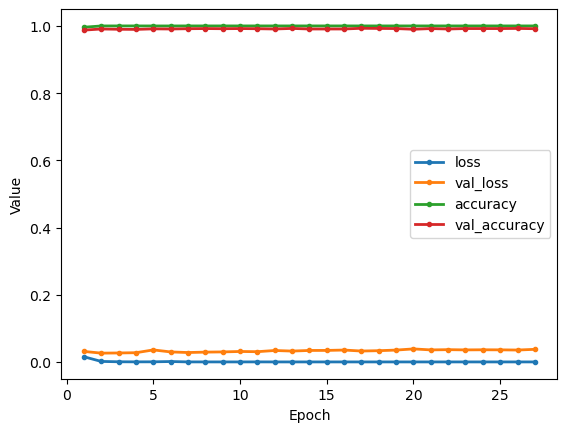

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/95 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step

 6/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step  

 9/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

14/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

19/95 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

24/95 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

29/95 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

34/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

39/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

44/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

49/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

54/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

59/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

64/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

69/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

74/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

79/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

84/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

90/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


 1/95 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step

 6/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step  

11/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

36/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

41/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

46/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

51/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

56/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

61/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

66/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

71/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

76/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

81/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

92/95 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [25]:
report.save()

Report saved as Output/Reports/M-type_MADS/report_MX7U9RC9.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################